### Settings

In [1]:
import sys
import os
path = os.path.abspath("../../VecRepV3") 
sys.path.append(path)
print(path)

/home/jovyan/VecRepV3


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

from collections import defaultdict
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models
import src.data_processing.Utilities as utils
import src.helpers.FilepathUtils as Futils
import src.data_processing.EmbeddingFunctions as embedfunc

from src.visualization import SamplingMethod, BFmethod
from src.data_processing.SampleEstimator import SampleEstimator
from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(device)

/home/jovyan/miniconda3/envs/test/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


cuda


In [ ]:
# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]

dimensions = 64

imageType = "shapes_3_dims_24_4" #10x10 triangle in 16x16 matrix shapes_3_dims_10_3
filters = ["unique"]
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k = 7

model_directory = "model"

testSample = np.load('/home/jovyan/VecRepV3/data/test_images_16x16.npy')
print(testSample.shape)

# Visualiation and Calculation using 2 random inputs

(500, 32, 32)


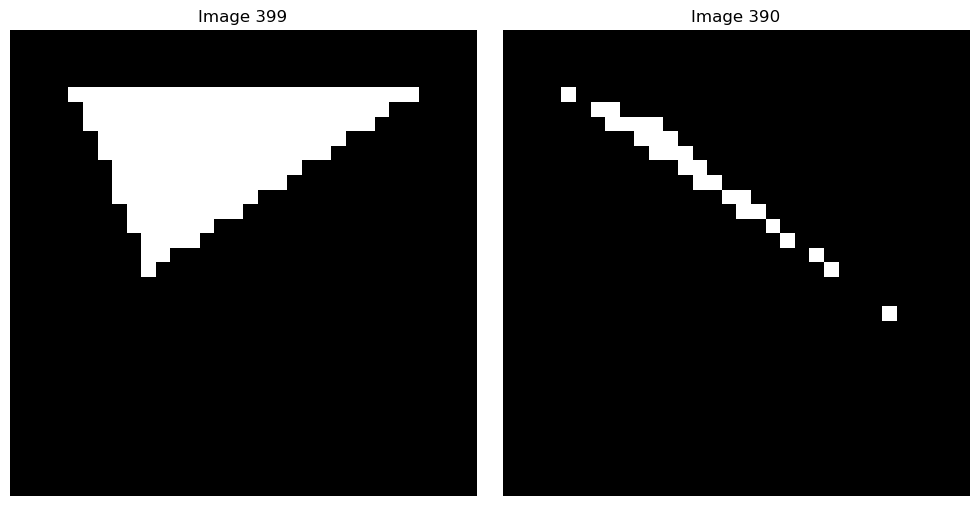

In [3]:
index1 = np.random.randint(len(testSample))
index2 = np.random.randint(len(testSample))
index1 = 399
index2 = 390
input1=testSample[index1]
input2=testSample[index2]

imgplt.plot_original_images(input1, input2, index1, index2)

# ------------------------- Preprocessing Dataset ------------------------
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 

stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]

In [4]:
model = models.SimpleCNN2(dimensions=dimensions, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                                              f'best_model_{imageType}_{dimensions}d_convlayer1.pt')))
model.eval()

/tmp/ipykernel_15802/2075414263.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model/m

SimpleCNN2(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (lpd): PolyphaseInvariantDown2D(
    (component_selection): LPS(
      (get_logits): LPSLogitLayersV2(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (relu): ReLU()
      )
    )
  )
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=64, bias=True)
)

### Visualisation of Loss score calculation -- Metric 1

In [5]:
#----------------------Metric 1 - Loss Calculation-----------------
NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss Calculation")
print("\nScaled NCC: ",NCC_scaled_value)

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]

dot_product_value = imgcalc.get_dp_score(model_vectors[index1], model_vectors[index2])

print("\nDot product value of model embeddings: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)

dot_product_matrix = np.dot(matrixA.T, matrixA)
dot_product_value_Pencorr = dot_product_matrix[index1][index2]
difference = abs(dot_product_value_Pencorr - dot_product_value)

print("\nDot product value of BF Method embeddings: ", dot_product_value_Pencorr)

train_loss_value = imgcalc.get_loss_value(torch.tensor(dot_product_value_Pencorr), NCC_scaled_value) 
print("Loss: ", train_loss_value)
print("\nDifference in values of BF Method and Model Method: ", difference.item())


Loss Calculation

Scaled NCC:  -0.36786043643951416
Dot product value of model:  -0.5449707508087158
Loss:  0.17711031436920166

Dot product value of BF Method:  -0.2218166672991591
Loss:  0.14604376256465912
Difference in values of BF Method and Model Method:  0.323154091835022


### Visualisation of KNN-IoU K score calculation -- Metric 2

----------------
Brute Force Method -- KNN-IOU score
----------------
Estimating K-Score for Image 399: K-Score = 0.6
Intersection sets : [  4  40 260 313 399 479]
Union sets: [  4   8  40 190 232 260 292 313 399 479]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   399                    1.000000                            1.000000
     4                    0.808870                            0.920043
     8                    0.781624                            0.910561
    40                    0.879683                            0.981018
   190                    0.801680                            0.898484
   232                    0.782198                            0.902072
   260                    0.865615                            0.975520
   292                    0.749277                            0.912925
   313                    0.868261                            0.959378
   479                    0.81

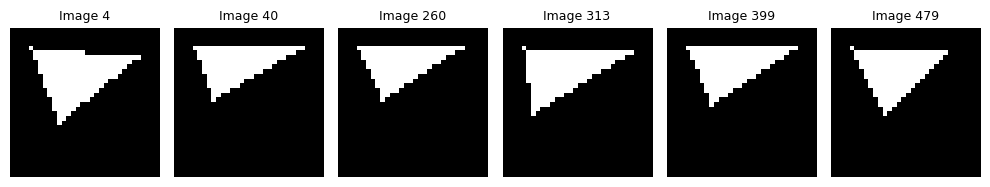


Plotting images in the union set:


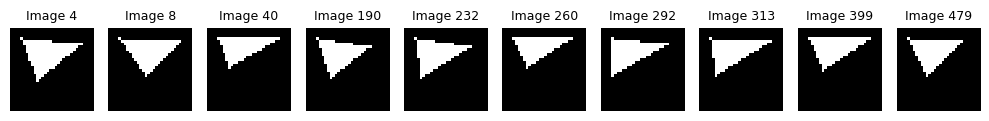


For translationally unique plots: 
Image 4 has no translationally similar images.
Image 8 has no translationally similar images.
Image 40 has no translationally similar images.
Image 190 has no translationally similar images.
Image 232 has no translationally similar images.
Image 260 has no translationally similar images.
Image 292 has no translationally similar images.
Image 313 has no translationally similar images.
Image 399 has no translationally similar images.
Image 479 has no translationally similar images.

Plotting images in the intersection set:


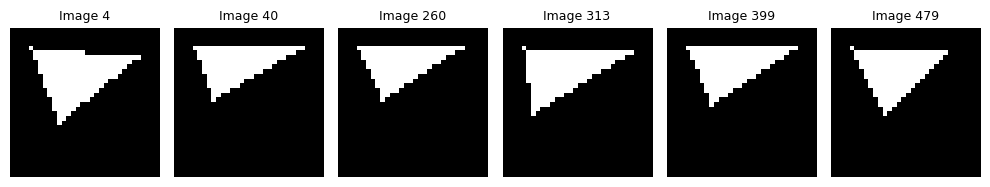


Plotting images in the union set:


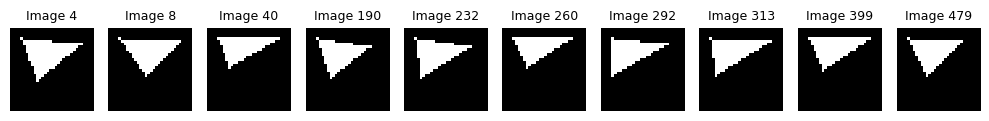


Top 20 values of Vector b
Rank 1: Value = 1.0, Index = 399
Rank 2: Value = 0.8796833753585815, Index = 40
Rank 3: Value = 0.8682607412338257, Index = 313
Rank 4: Value = 0.8656150102615356, Index = 260
Rank 5: Value = 0.8149276971817017, Index = 479
Rank 6: Value = 0.8088698387145996, Index = 4
Rank 7: Value = 0.8016802072525024, Index = 190
Rank 8: Value = 0.7821977138519287, Index = 232
Rank 9: Value = 0.7816237211227417, Index = 8
Rank 10: Value = 0.7765846252441406, Index = 458
Rank 11: Value = 0.7678283452987671, Index = 98
Rank 12: Value = 0.7631202936172485, Index = 480
Rank 13: Value = 0.759028434753418, Index = 90
Rank 14: Value = 0.7587170600891113, Index = 293
Rank 15: Value = 0.7572817802429199, Index = 222
Rank 16: Value = 0.7570953369140625, Index = 81
Rank 17: Value = 0.7561080455780029, Index = 67
Rank 18: Value = 0.7492773532867432, Index = 292
Rank 19: Value = 0.7472881078720093, Index = 215
Rank 20: Value = 0.7433241605758667, Index = 492

Top 20 values of Vector c


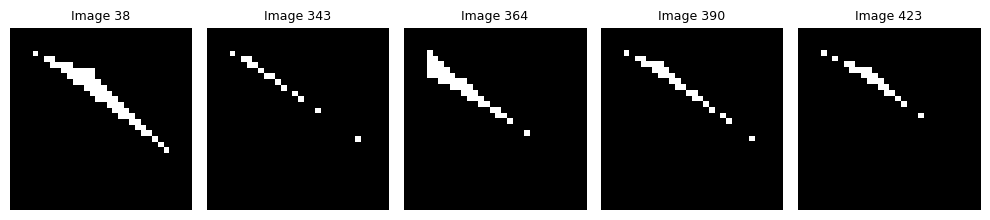


Plotting images in the union set:


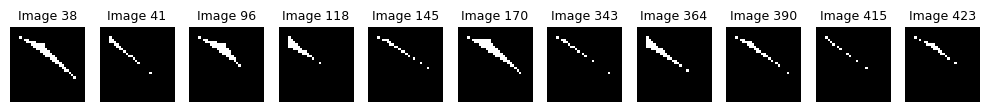


For translationally unique plots: 
Image 38 has no translationally similar images.
Image 41 has no translationally similar images.
Image 96 has no translationally similar images.
Image 118 has no translationally similar images.
Image 145 has no translationally similar images.
Image 170 has no translationally similar images.
Image 343 has no translationally similar images.
Image 364 has no translationally similar images.
Image 390 has no translationally similar images.
Image 415 has no translationally similar images.
Image 423 has no translationally similar images.

Plotting images in the intersection set:


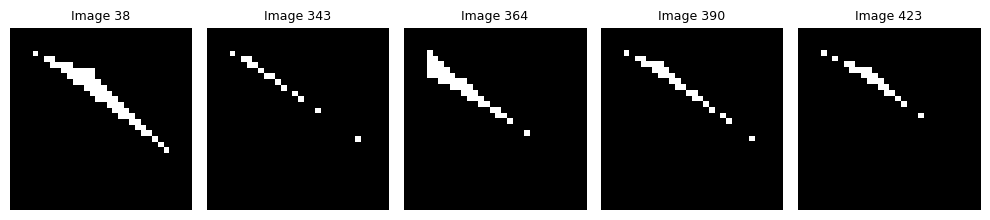


Plotting images in the union set:


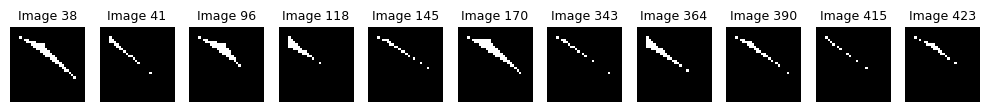


Top 20 values of Vector b
Rank 1: Value = 1.0, Index = 390
Rank 2: Value = 0.7118419408798218, Index = 423
Rank 3: Value = 0.4675987958908081, Index = 343
Rank 4: Value = 0.4634549617767334, Index = 364
Rank 5: Value = 0.36061835289001465, Index = 118
Rank 6: Value = 0.3600184917449951, Index = 96
Rank 7: Value = 0.3469310998916626, Index = 38
Rank 8: Value = 0.3276714086532593, Index = 170
Rank 9: Value = 0.32221484184265137, Index = 73
Rank 10: Value = 0.3158978223800659, Index = 352
Rank 11: Value = 0.31558704376220703, Index = 41
Rank 12: Value = 0.3054279088973999, Index = 287
Rank 13: Value = 0.30542778968811035, Index = 305
Rank 14: Value = 0.29430055618286133, Index = 145
Rank 15: Value = 0.2747548818588257, Index = 99
Rank 16: Value = 0.2601238489151001, Index = 139
Rank 17: Value = 0.2403472661972046, Index = 415
Rank 18: Value = 0.22034049034118652, Index = 478
Rank 19: Value = 0.21626055240631104, Index = 361
Rank 20: Value = 0.21028459072113037, Index = 164

Top 20 values

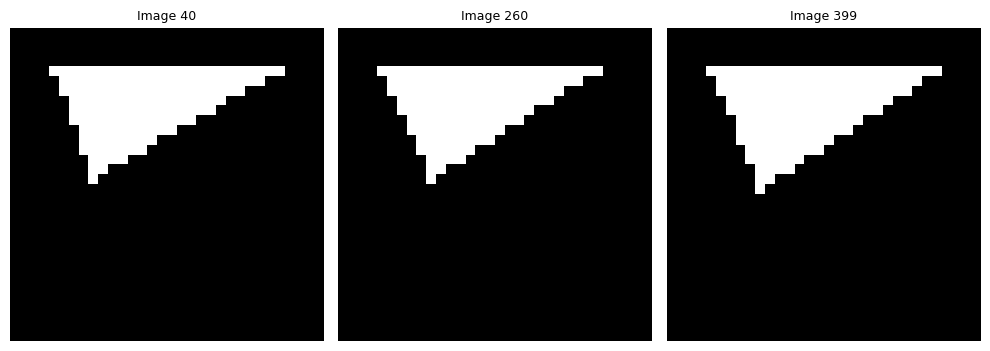


Plotting images in the union set:


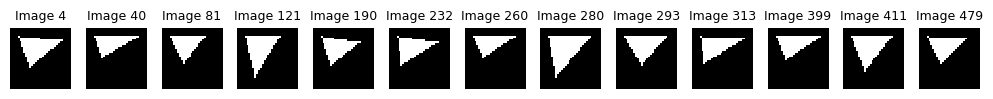


For translationally unique plots: 
Image 4 has no translationally similar images.
Image 40 has no translationally similar images.
Image 81 has no translationally similar images.
Image 121 has no translationally similar images.
Image 190 has no translationally similar images.
Image 232 has no translationally similar images.
Image 260 has no translationally similar images.
Image 280 has no translationally similar images.
Image 293 has no translationally similar images.
Image 313 has no translationally similar images.
Image 399 has no translationally similar images.
Image 411 has no translationally similar images.
Image 479 has no translationally similar images.

Plotting images in the intersection set:


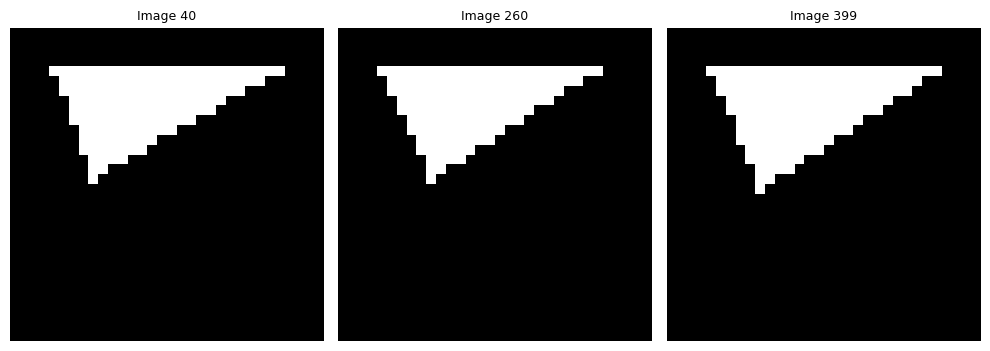


Plotting images in the union set:


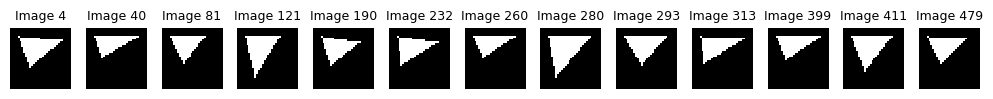

Estimating K-Score for Image 390: K-Score = 0.23076923076923078
Intersection sets : [343 390 423]
Union sets: [ 38  45  96 117 118 145 170 291 343 364 390 423 426]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   390                    1.000000                            1.000000
    38                    0.346931                            0.472464
    45                   -0.461538                            0.675502
    96                    0.360018                            0.494099
   117                   -0.266201                            0.658331
   118                    0.360618                            0.536011
   145                    0.294301                            0.689623
   170                    0.327671                            0.636566
   291                   -0.473765                            0.676812
   343                    0.467599                            0.724261
   364       

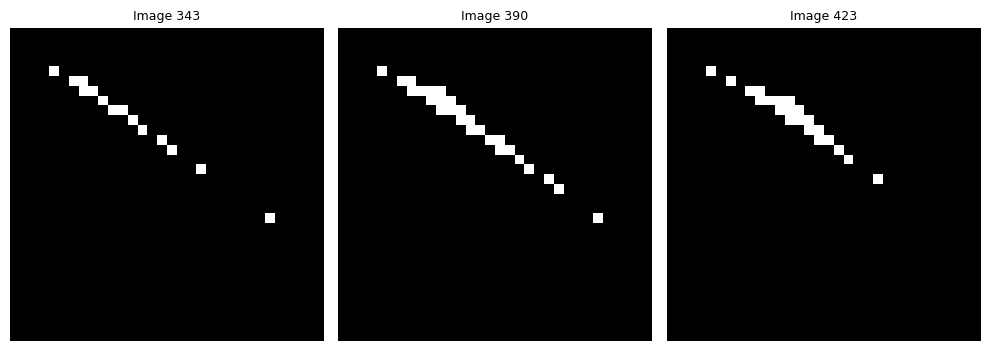


Plotting images in the union set:


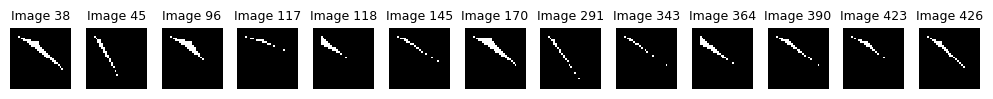


For translationally unique plots: 
Image 38 has no translationally similar images.
Image 45 has no translationally similar images.
Image 96 has no translationally similar images.
Image 117 has no translationally similar images.
Image 118 has no translationally similar images.
Image 145 has no translationally similar images.
Image 170 has no translationally similar images.
Image 291 has no translationally similar images.
Image 343 has no translationally similar images.
Image 364 has no translationally similar images.
Image 390 has no translationally similar images.
Image 423 has no translationally similar images.
Image 426 has no translationally similar images.

Plotting images in the intersection set:


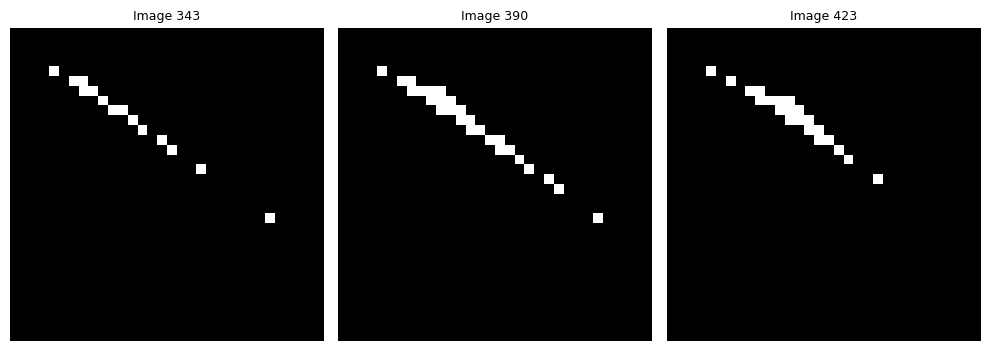


Plotting images in the union set:


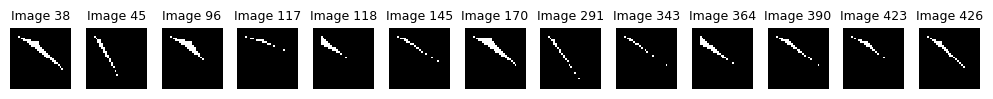

(array([343, 390, 423]),
 [38, 45, 96, 117, 118, 145, 170, 291, 343, 364, 390, 423, 426])

In [10]:
#----------------------Metric 2 - KNNIoU-----------------
print("----------------\nBrute Force Method -- KNN-IOU score\n----------------")
vectorb_bf1 = matrixG[index1]
vectorc_bf1 = imgcalc.get_vectorc_brute(index1, matrixA)
_, indices = imgplt.display_and_plot_results(vectorb_bf1, vectorc_bf1, "Brute Force", index1, k, testSample)

top_values_b_1, _ = imgcalc.get_top_scores(vectorb_bf1, len(indices), vectorc_bf1)
bottom_values_b_1, _ = imgcalc.get_bottom_scores(vectorb_bf1, len(indices), vectorc_bf1)
    
vectorb_bf2 = matrixG[index2]
vectorc_bf2 = imgcalc.get_vectorc_brute(index2, matrixA)
imgplt.display_and_plot_results(vectorb_bf2, vectorc_bf2, "Brute Force", index2, k, testSample)

top_values_b_2, _ = imgcalc.get_top_scores(vectorb_bf2, len(indices), vectorc_bf2)
bottom_values_b_2, _ = imgcalc.get_bottom_scores(vectorb_bf2, len(indices), vectorc_bf2)

print("----------------\nModel Method -- KNN-IOU score\n----------------")
vectorb_model1 = matrixG[index1]
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, testSample)

vectorb_model2 = matrixG[index2]
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, testSample)

### Visualisation of Mean Squared Difference of **original** matrix and vector embedding -- Metric 3

In [6]:
# -----------------------------Before transforming output embedding matrices-----------------------------
# ----------- Preprocessing dataset -------------
dim = 64
embeddingType = f"pencorr_{dim}"

model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                 f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

model.eval()

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_matrix = imgcalc.get_matrix_embeddings(input_dataset, model_vectors)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
dot_product_matrix = np.dot(matrixA.T, matrixA)

######################################################
mean_squared_difference = imgcalc.get_MSE(matrixG, dot_product_matrix)
print("Mean Squared Difference of Matrices -- Pencorr (A'A) and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix.detach().cpu().numpy())
print("\nMean Squared Difference of of Matrices -- Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix.detach().cpu().numpy())
print("Mean Squared Difference of of Matrices -- Model and Pencorr (A'A):", mean_squared_difference)
    
print(f"\nPrinting matrices")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix.detach().cpu().numpy()}, {model_matrix.detach().cpu().numpy().shape}")

print(f"\nPrinting vectors")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Embeddings -- Pencorr (A) and Model: {mean_squared_difference}")

Mean Squared Difference of Pencorr (A'A) and NCC (G): 0.3230924922125886

Mean Squared Difference of Model and NCC (G): 0.7961394876907782
Mean Squared Difference of Model and Pencorr (A'A): 0.5089548148213883

Printing matrices

Matrix G: [[ 1.         -0.65184468 -0.47018713 ... -0.75520396 -0.64365166
  -0.61025807]
 [-0.65184468  1.         -0.30828559 ... -0.16903645  0.2561537
   0.15337098]
 [-0.47018713 -0.30828559  1.         ... -0.51363957  0.27438617
  -0.53539678]
 ...
 [-0.75520396 -0.16903645 -0.51363957 ...  1.         -0.08405721
  -0.09363103]
 [-0.64365166  0.2561537   0.27438617 ... -0.08405721  1.
  -0.13197589]
 [-0.61025807  0.15337098 -0.53539678 ... -0.09363103 -0.13197589
   1.        ]]

Matrix A'A (Pencorr): [[ 1.         -0.40385153  0.17631002 ... -0.42973586 -0.42813806
  -0.22991002]
 [-0.40385153  1.         -0.15187719 ... -0.10746696  0.31210782
   0.22254778]
 [ 0.17631002 -0.15187719  1.         ... -0.2899779   0.34812124
  -0.29594212]
 ...
 [-0.4

### Visualisation of original vector embeddings of similar images across dimensions -- Metric 4

For dimension 32
[399, 40, 313, 260, 479, 4, 190, 232, 8, 458, 98, 480, 90, 293, 222, 81, 67, 292, 215, 492]


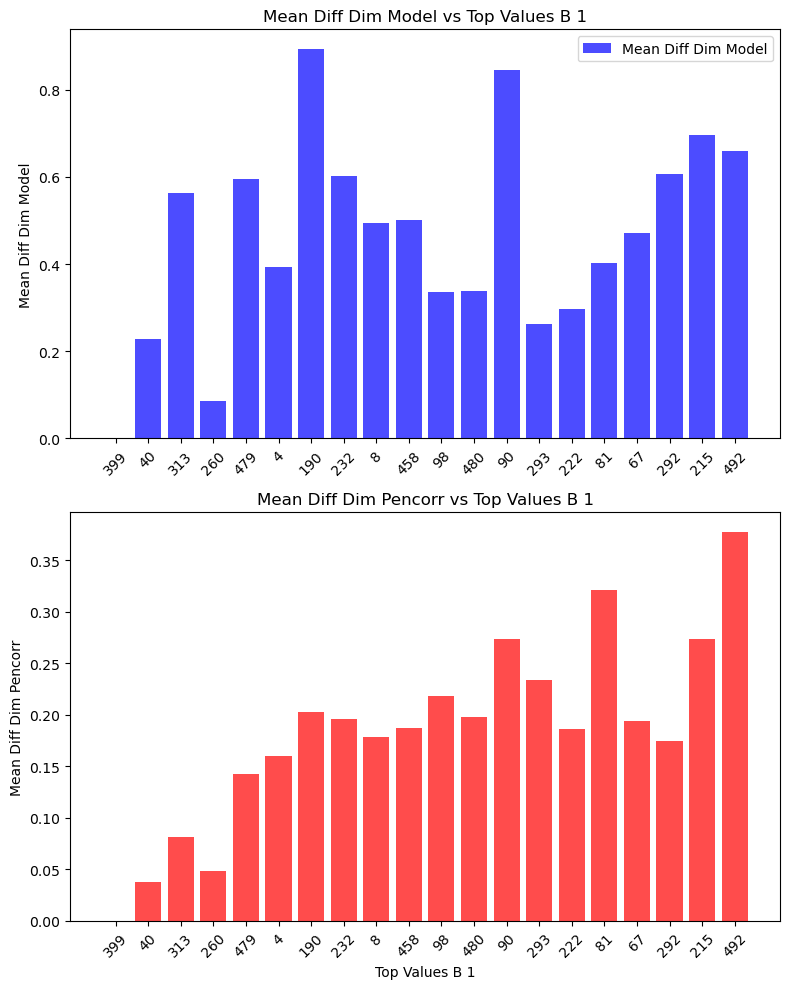

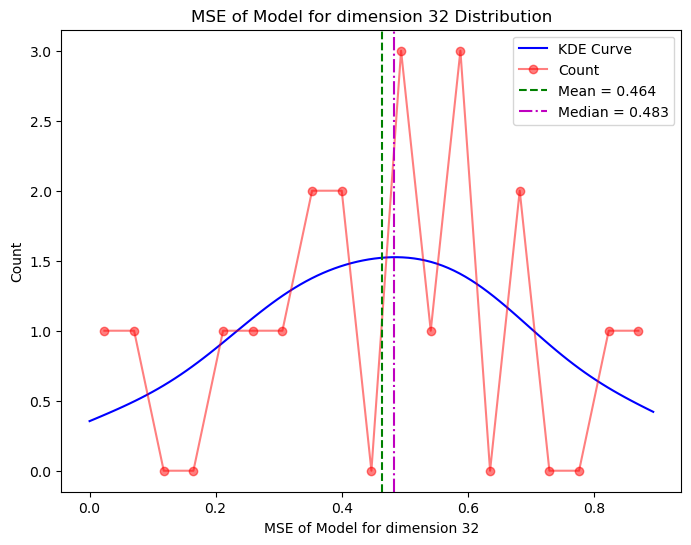

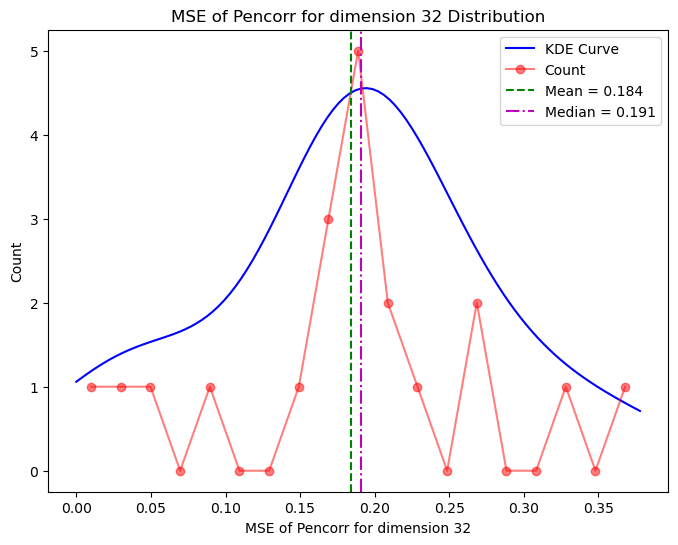

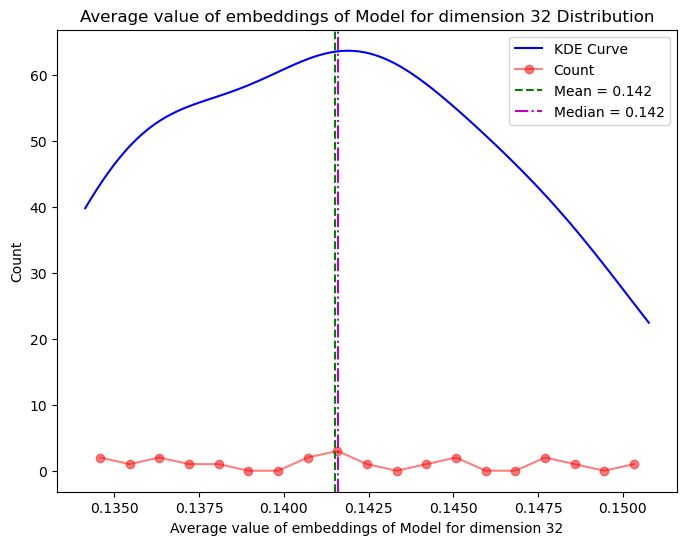

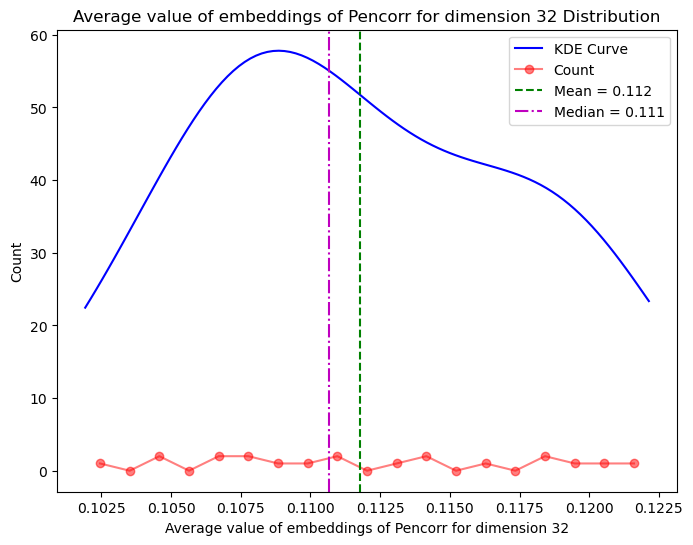

For dimension 64
[399, 40, 313, 260, 479, 4, 190, 232, 8, 458, 98, 480, 90, 293, 222, 81, 67, 292, 215, 492]


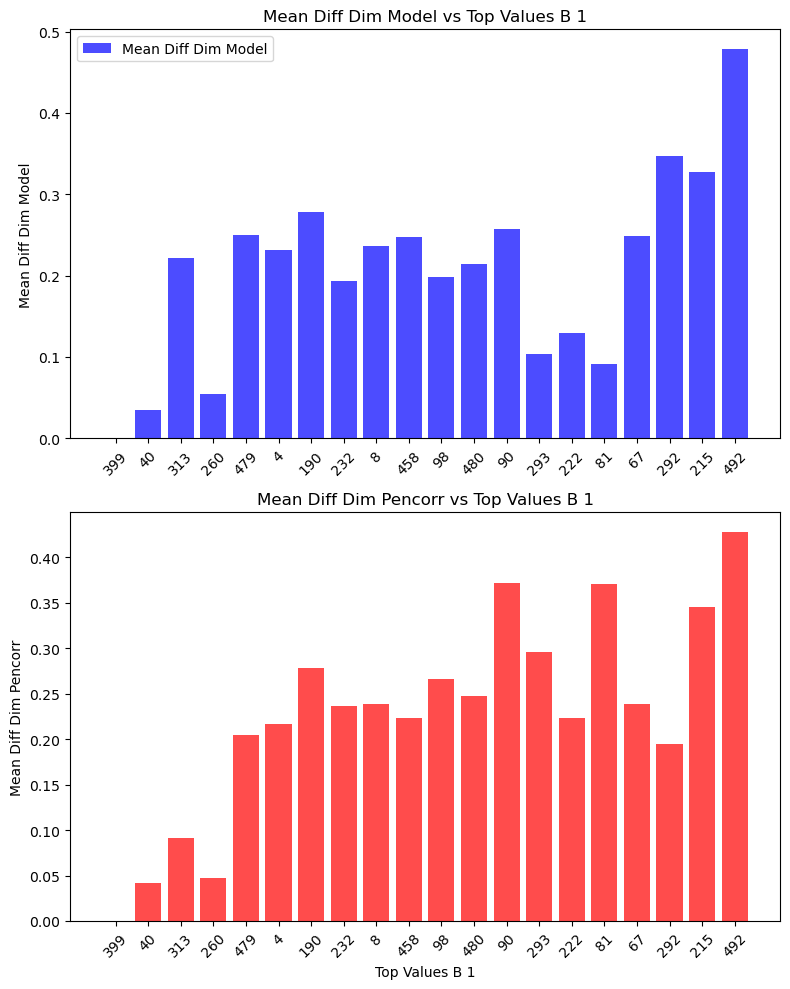

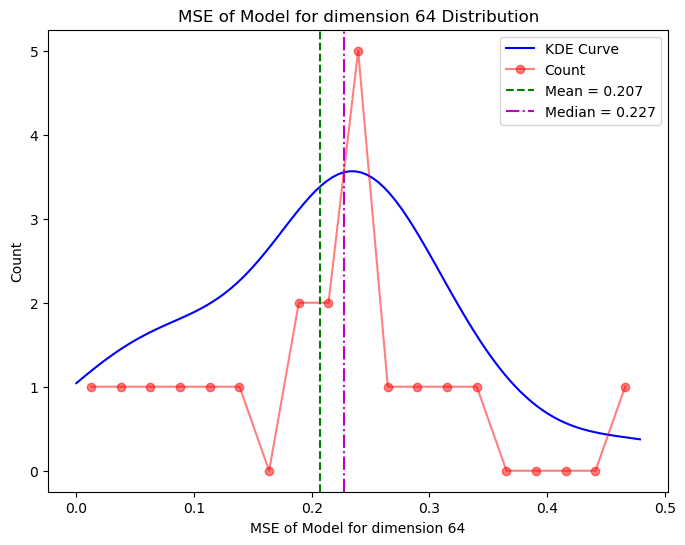

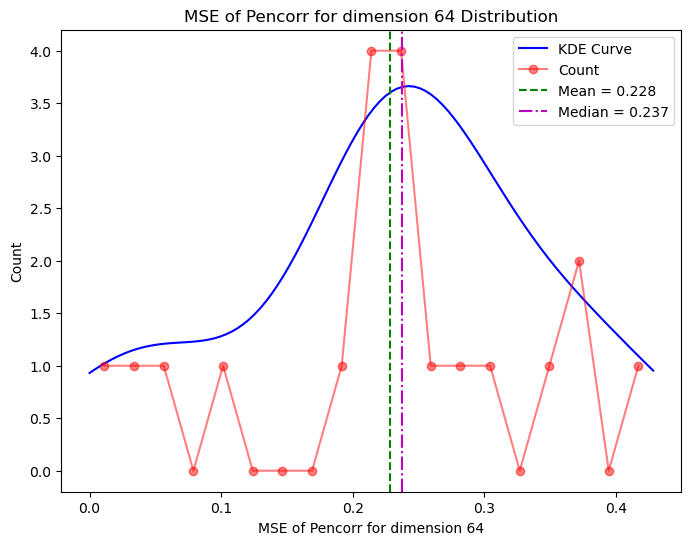

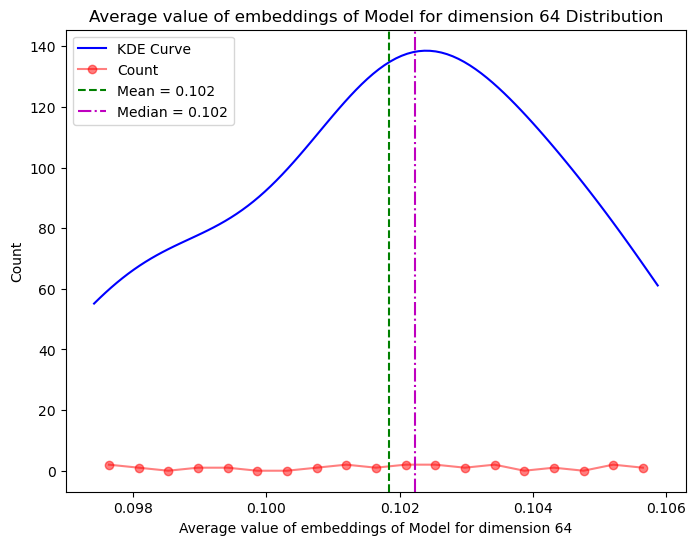

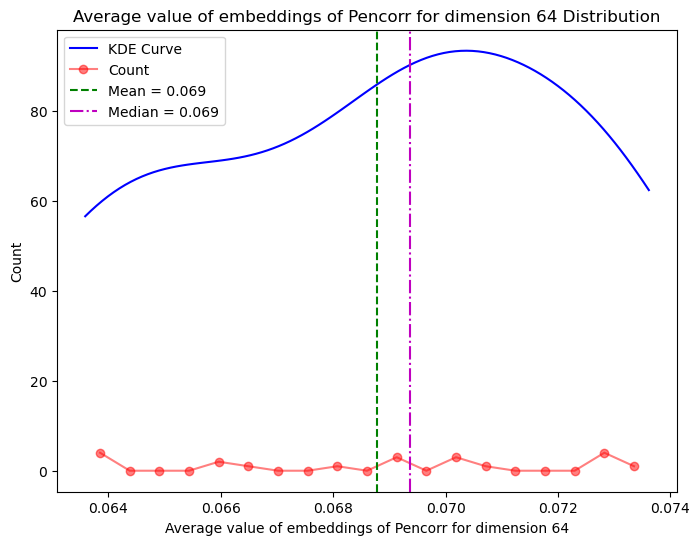

For dimension 128
[399, 40, 313, 260, 479, 4, 190, 232, 8, 458, 98, 480, 90, 293, 222, 81, 67, 292, 215, 492]


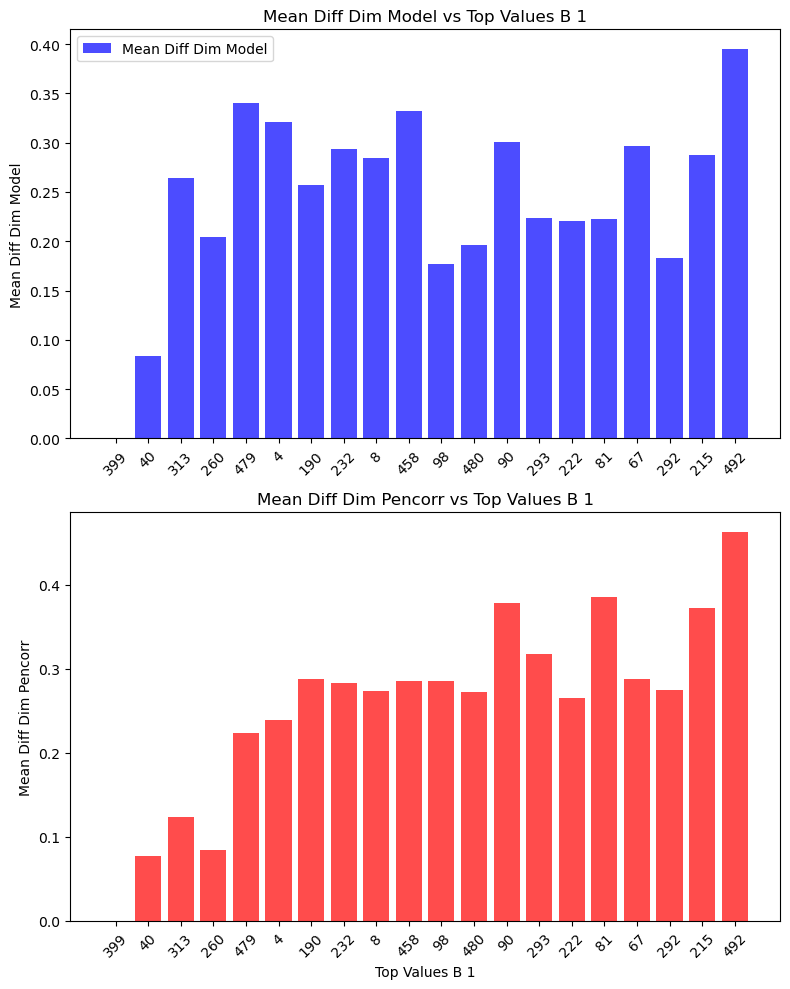

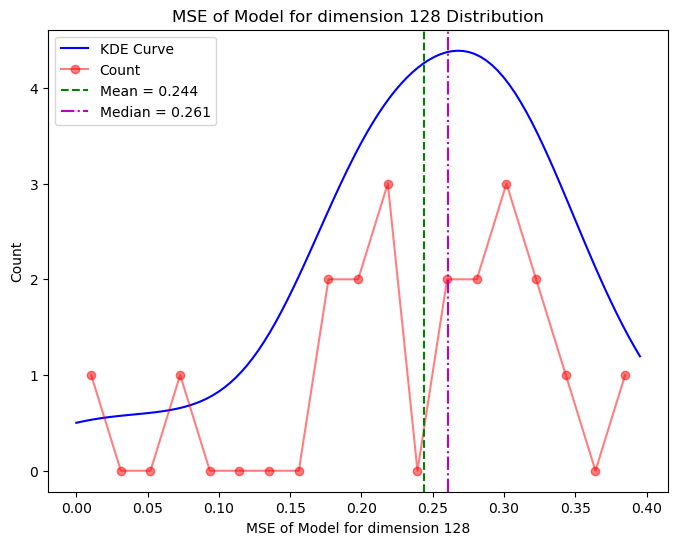

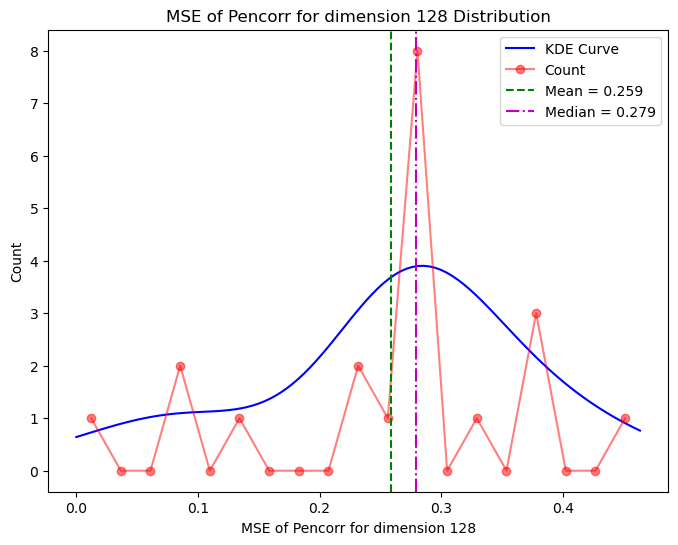

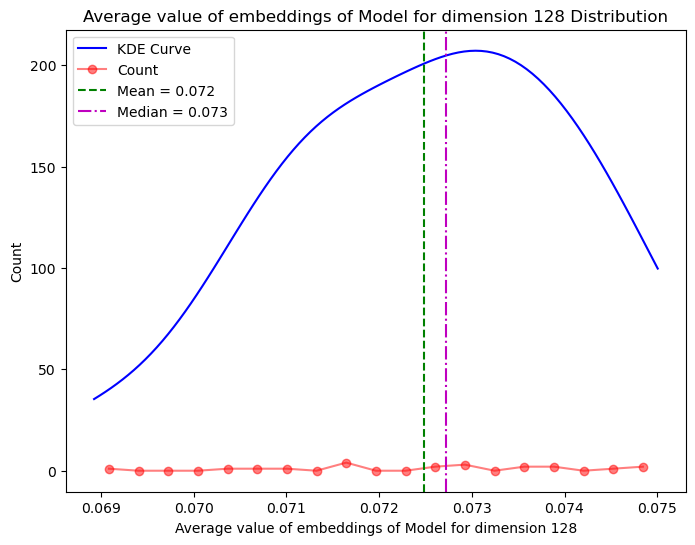

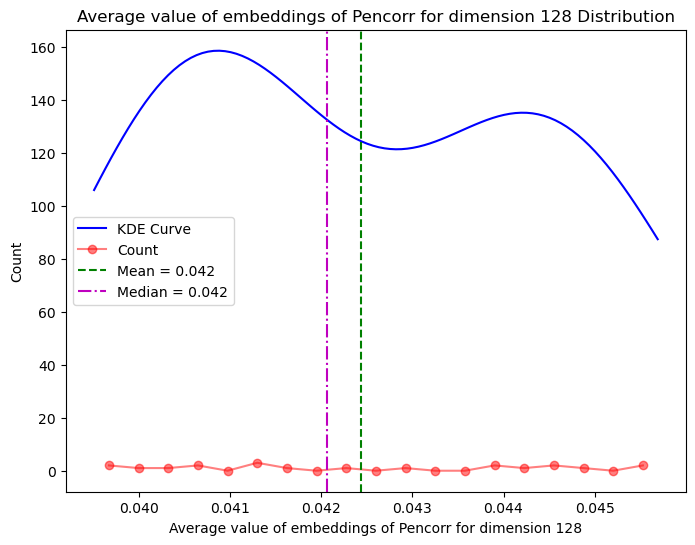

For dimension 256
[399, 40, 313, 260, 479, 4, 190, 232, 8, 458, 98, 480, 90, 293, 222, 81, 67, 292, 215, 492]


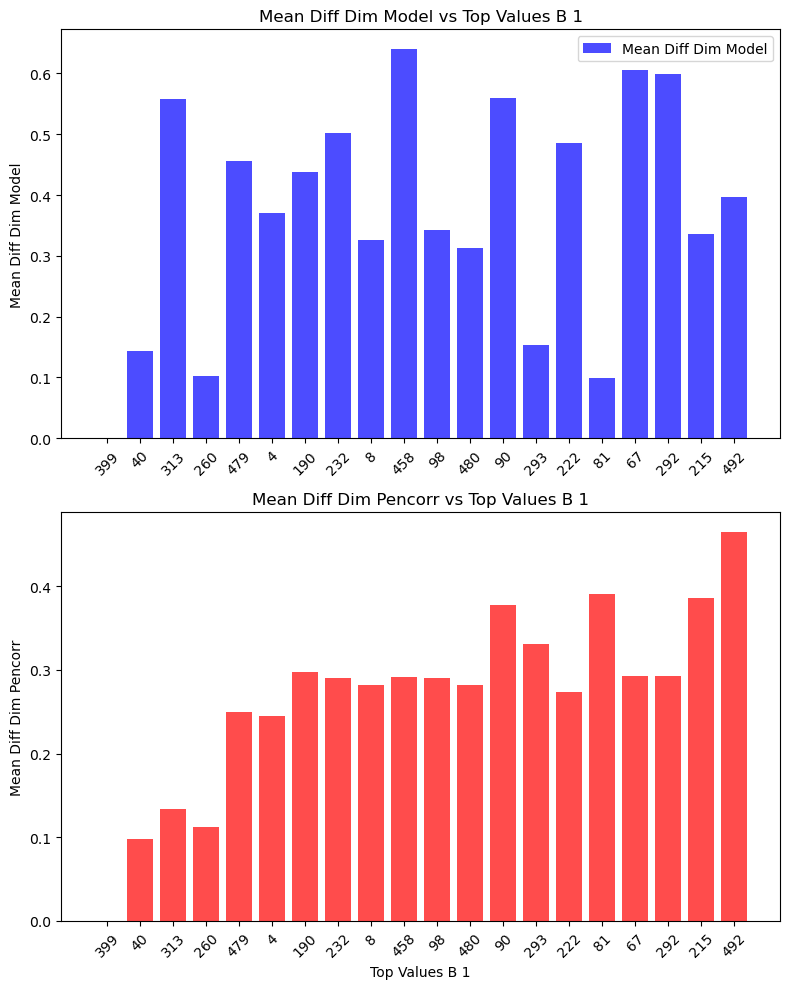

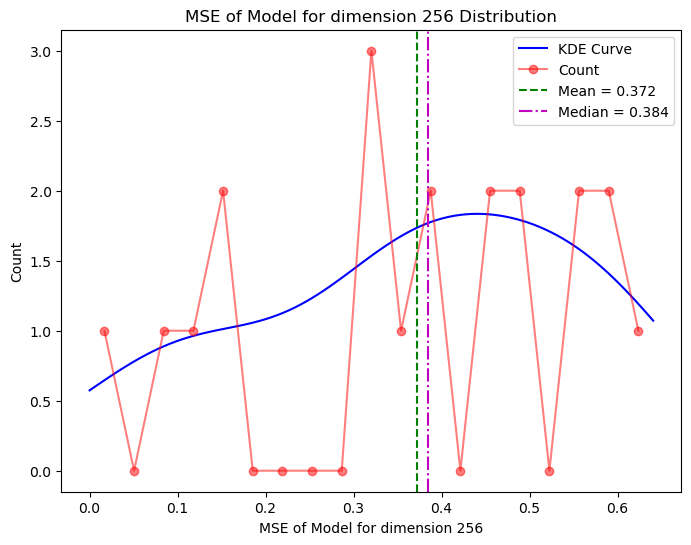

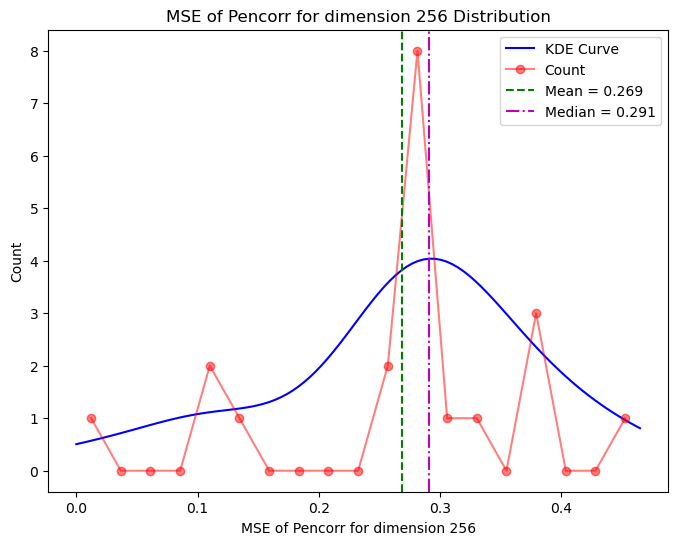

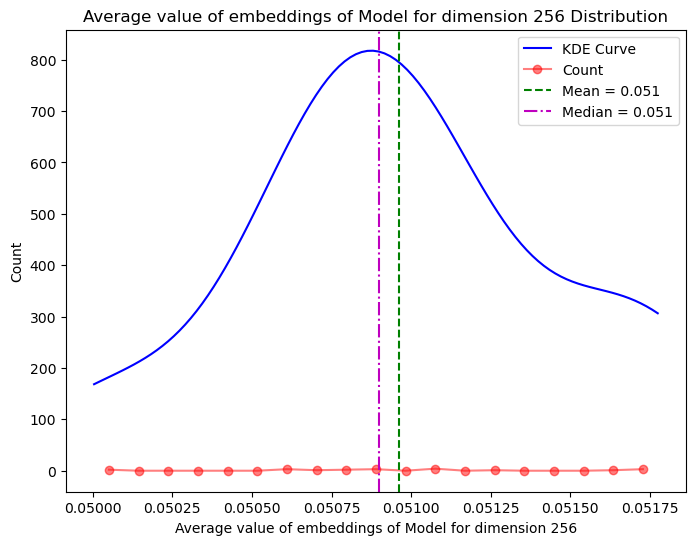

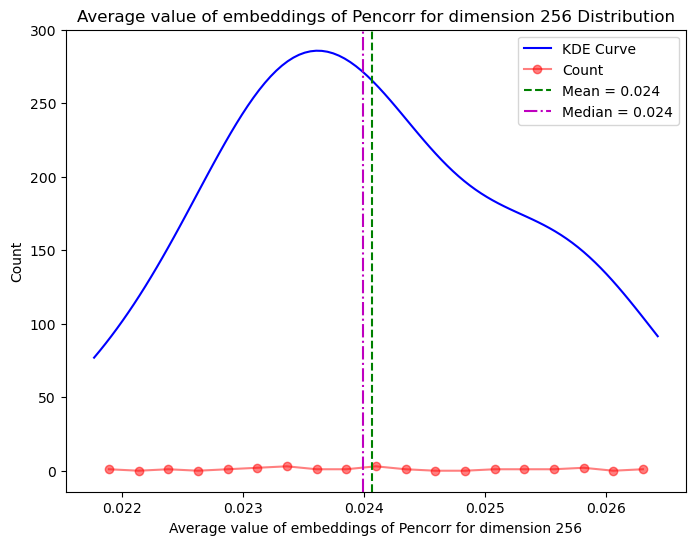

In [11]:
#comparison with similar images before transforming output embedding matrices
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [32, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(top_values_b_1)):
        top_1_index = top_values_b_1[i][0]
        # print(top_1_index)
        # print(f"\nPrinting vectors for index {index1}")
        # print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        # print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        # print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        # print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        # print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        # print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        # print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in top_values_b_1]
    print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

### Visualisation of original vector embeddings of different images across dimensions -- Metric 4

For dimension 32


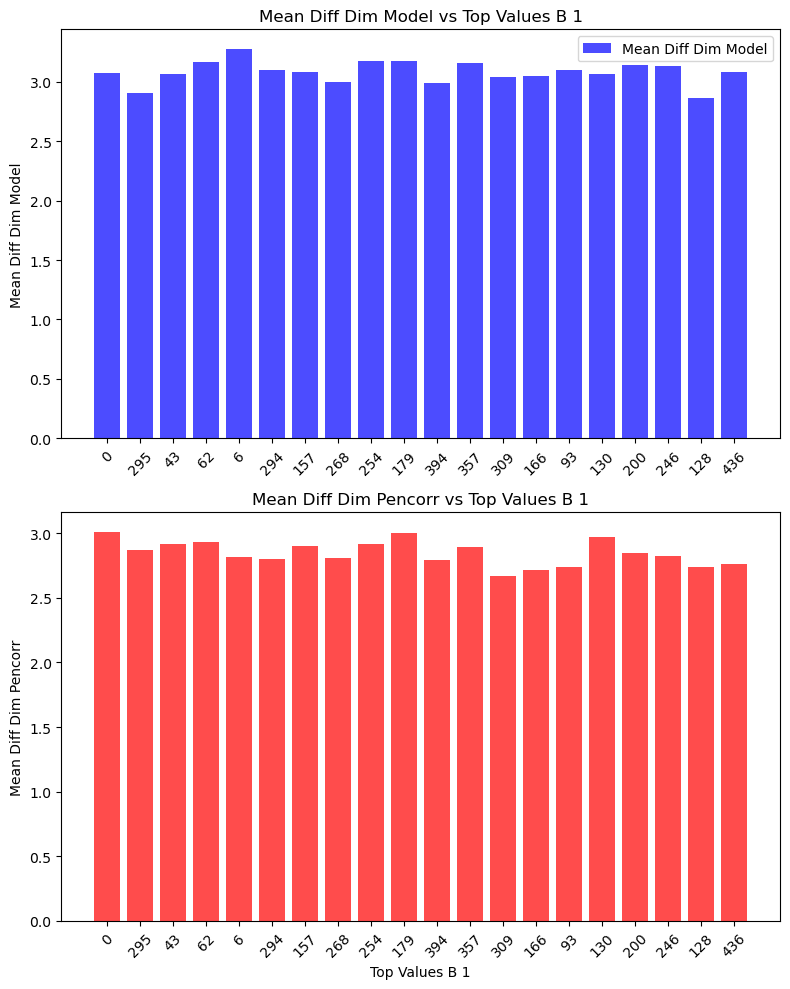

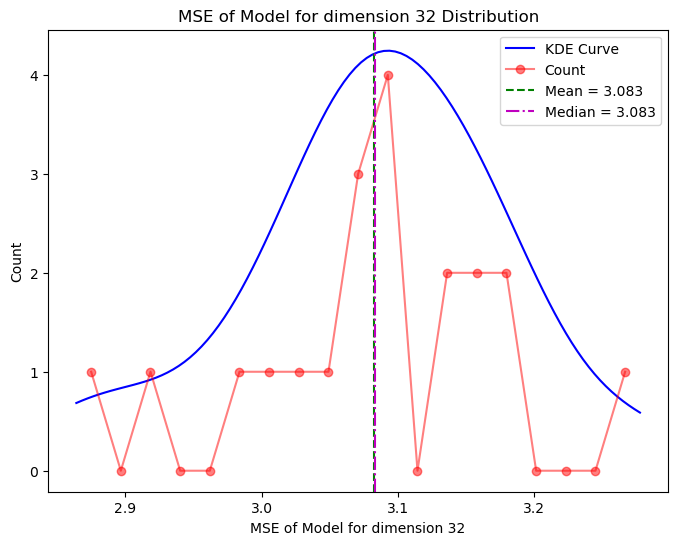

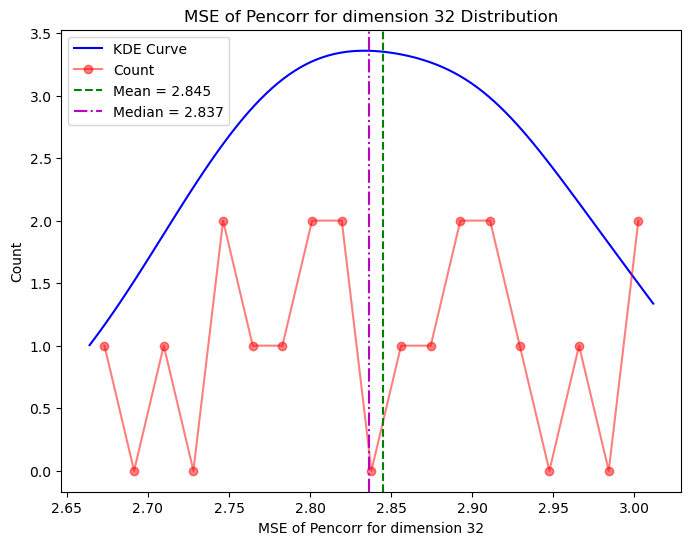

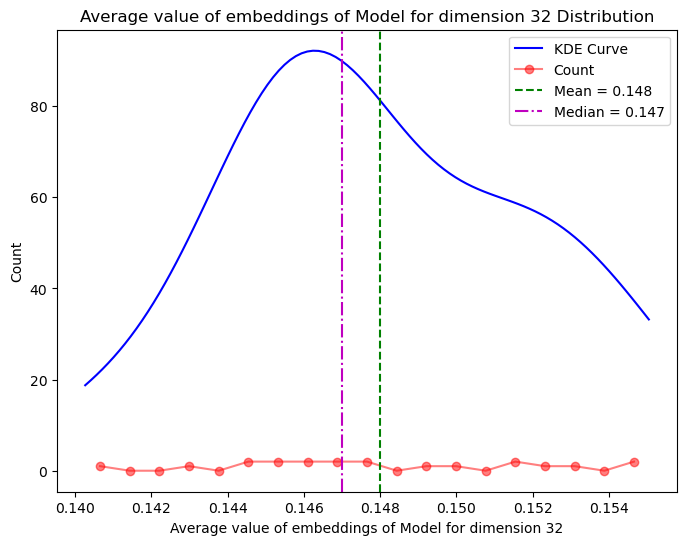

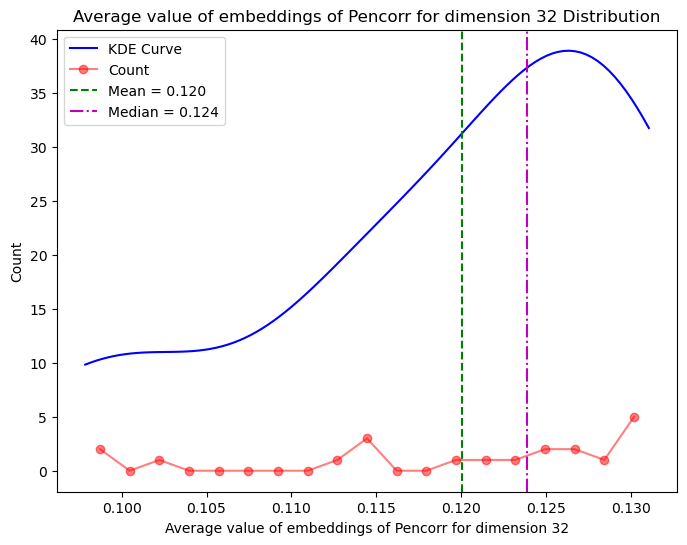

For dimension 64


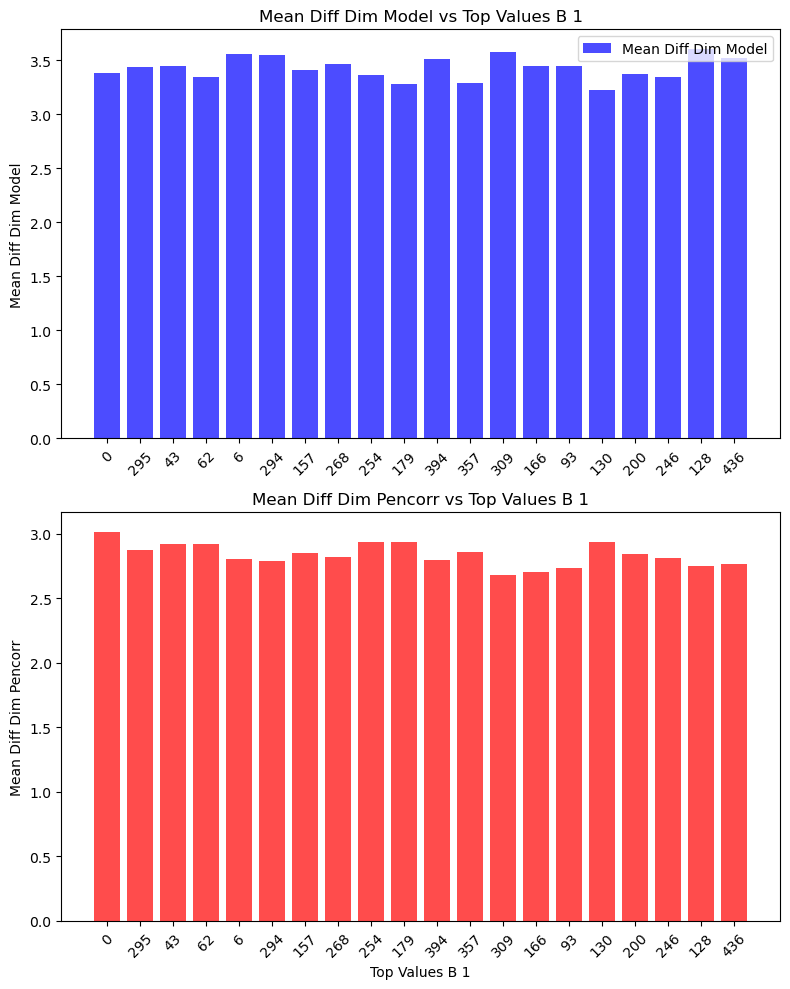

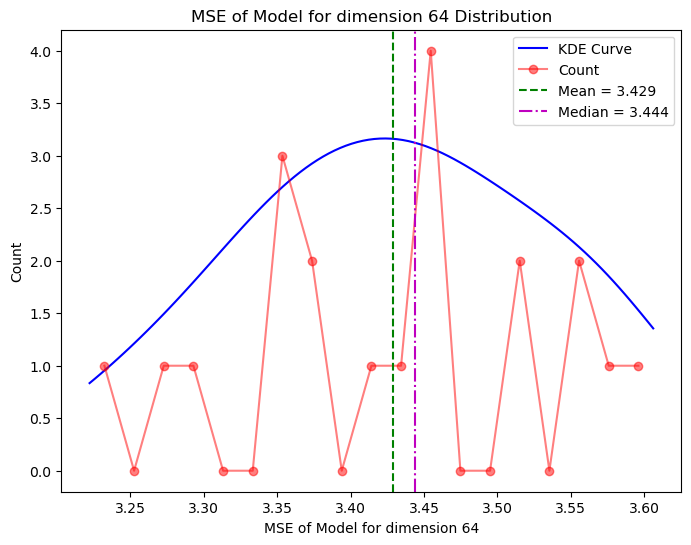

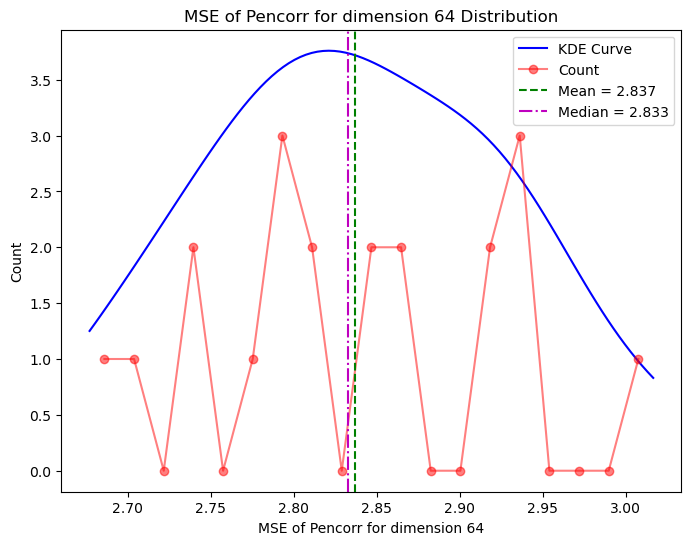

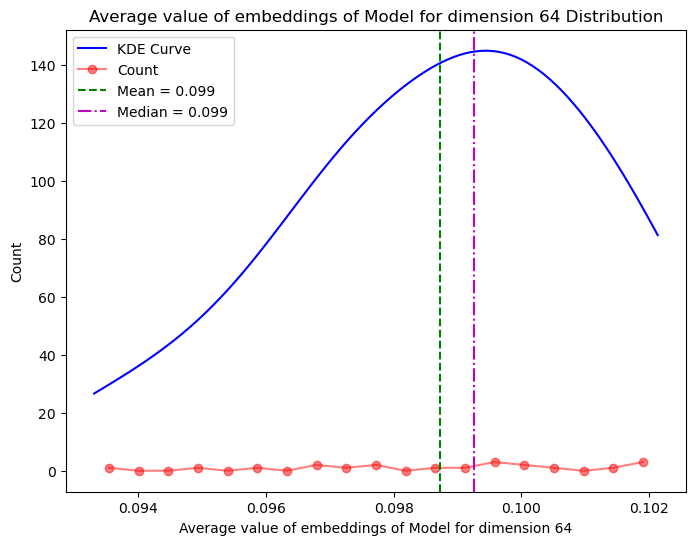

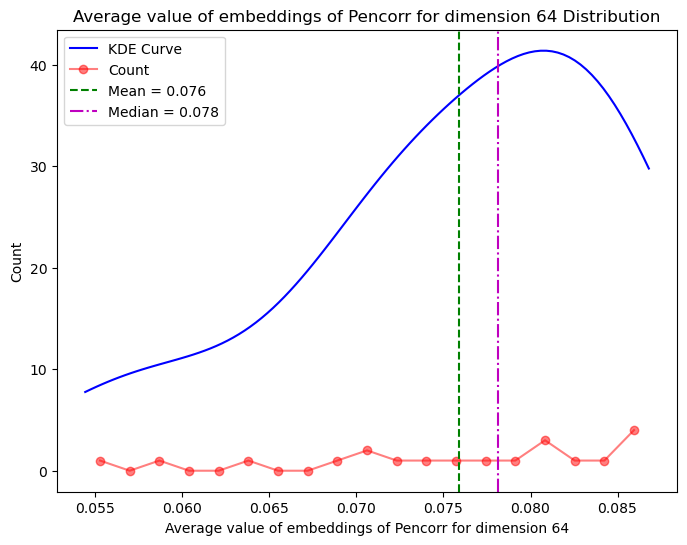

For dimension 128


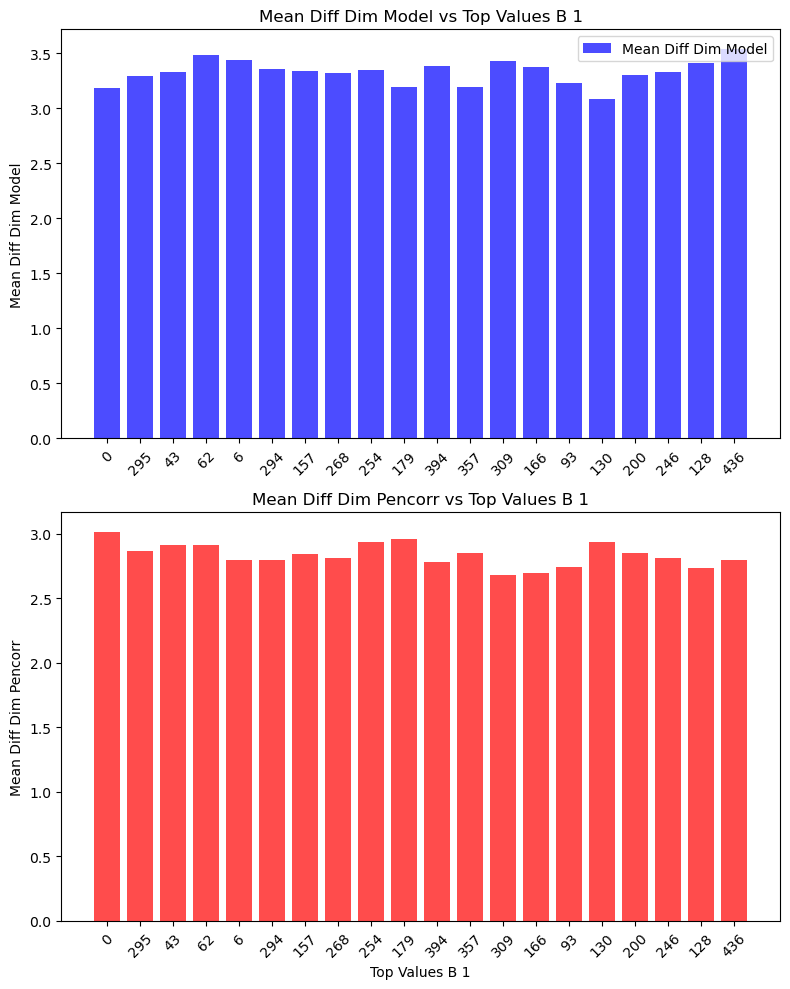

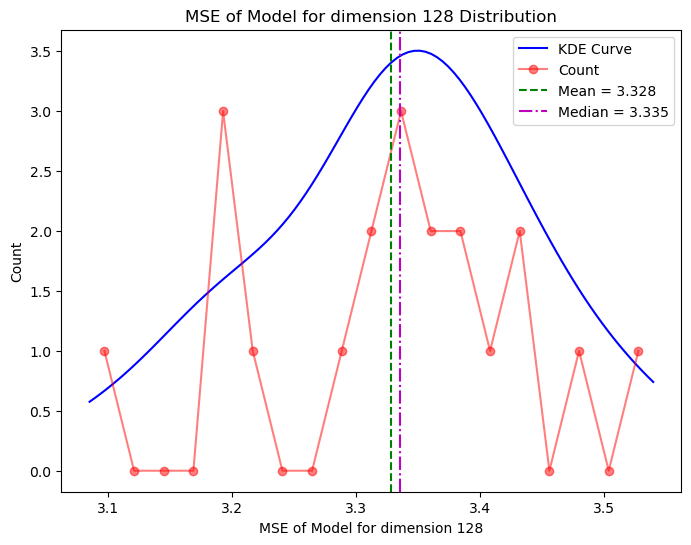

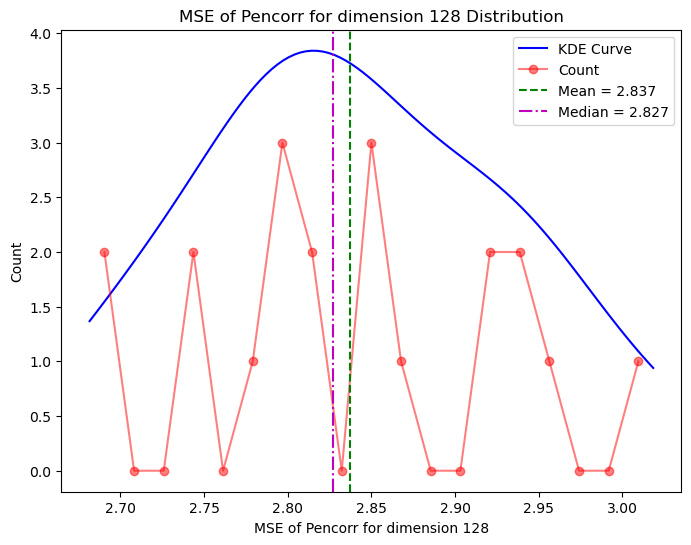

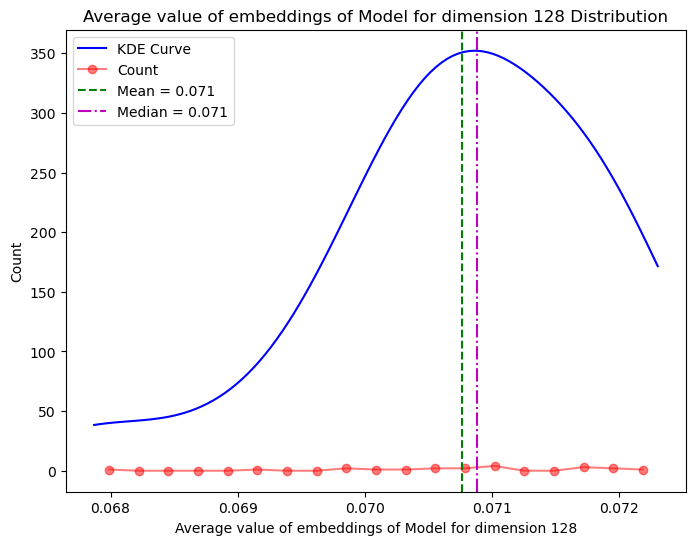

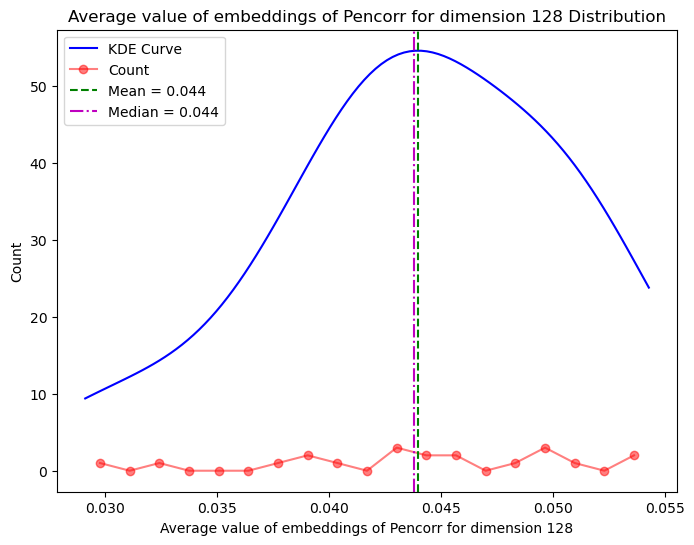

For dimension 256


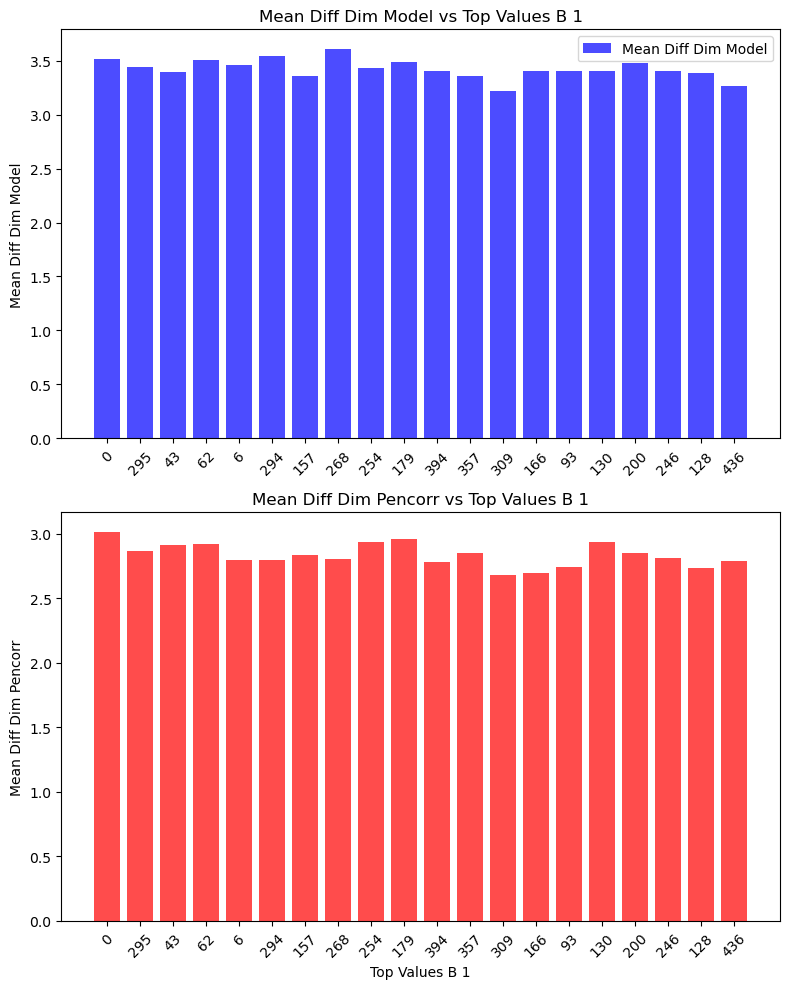

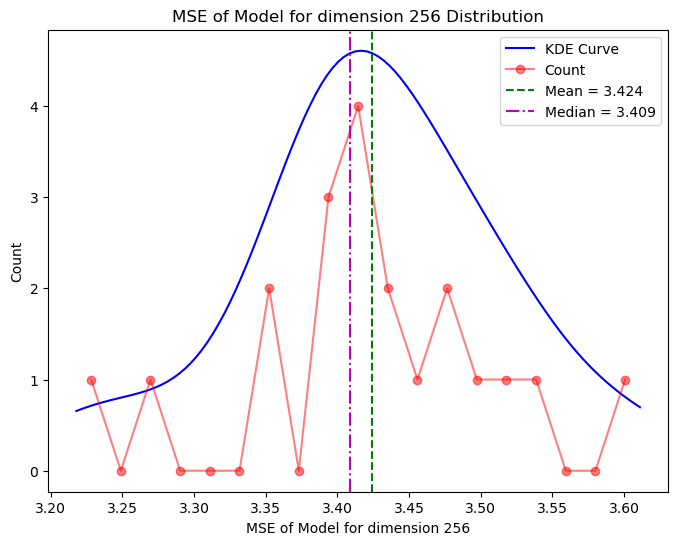

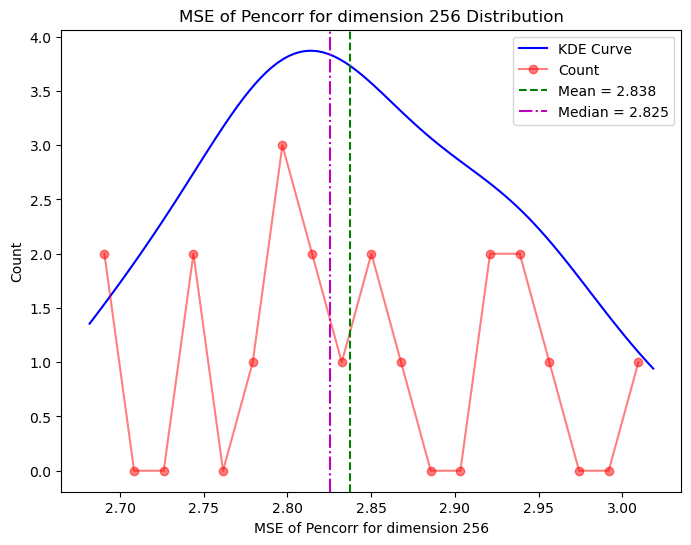

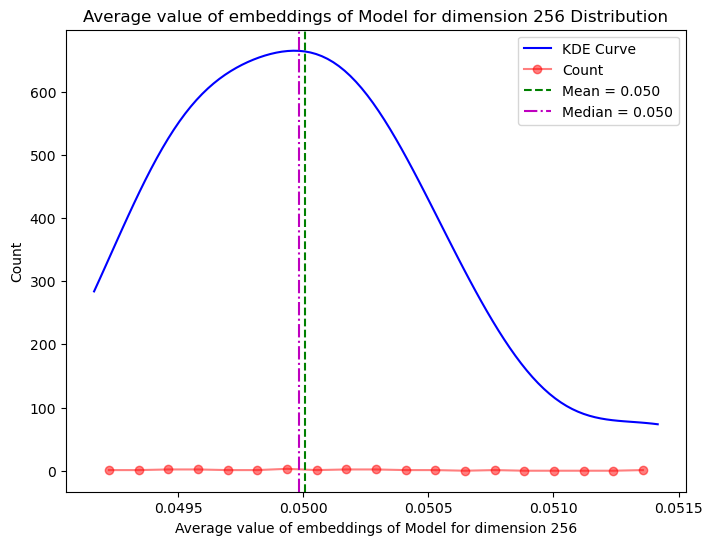

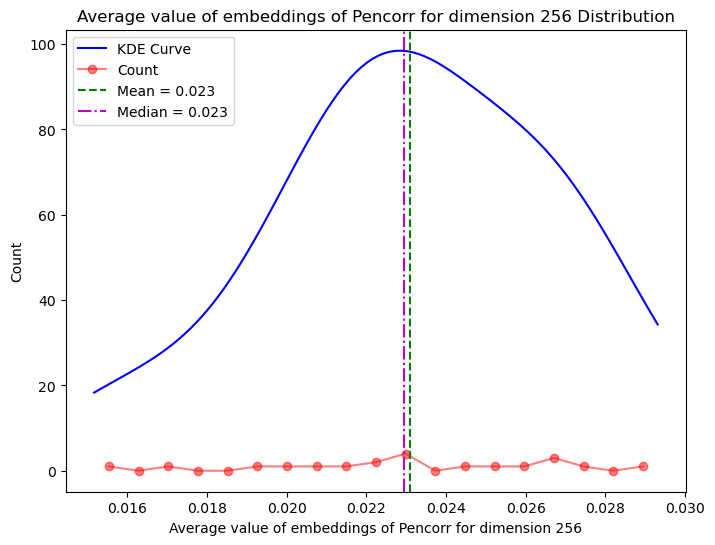

In [12]:
#comparison with different images
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [32, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(bottom_values_b_1)):
        top_1_index = bottom_values_b_1[i][0]
        # print(top_1_index)
        # print(f"\nPrinting vectors for index {index1}")
        # print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        # print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        # print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        # print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        # print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        # print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        # print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in bottom_values_b_1]
    # print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

# Visualiation and Calculation across dataset, across dimensions

## Metric 1 & 2: Loss and K-Score
### Visualisation of loss and k-score across dataset across dimensions

Dimension 32

NCC Interval		Average Loss
-0.1-0.0		0.3537 (20747 samples)
-0.2--0.1		0.4163 (22128 samples)
-0.3--0.2		0.4676 (21715 samples)
-0.4--0.3		0.5288 (22575 samples)
-0.5--0.4		0.5966 (21477 samples)
-0.6--0.5		0.6460 (18532 samples)
-0.7--0.6		0.7069 (11984 samples)
-0.8--0.7		0.8168 (4692 samples)
-0.9--0.8		0.8921 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.3116 (21562 samples)
0.1-0.2		0.2667 (20116 samples)
0.2-0.3		0.2324 (18407 samples)
0.3-0.4		0.1984 (14862 samples)
0.4-0.5		0.1821 (12001 samples)
0.5-0.6		0.1602 (8923 samples)
0.6-0.7		0.1403 (5511 samples)
0.7-0.8		0.1215 (2747 samples)
0.8-0.9		0.1201 (800 samples)
0.9-1.0		0.0183 (588 samples)


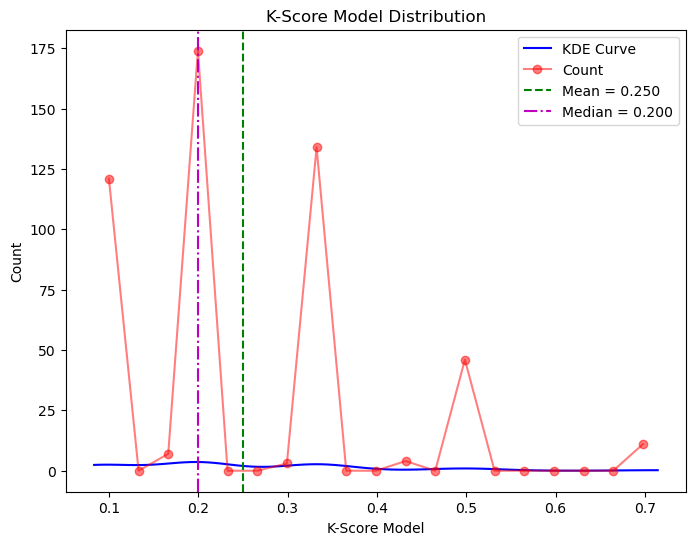

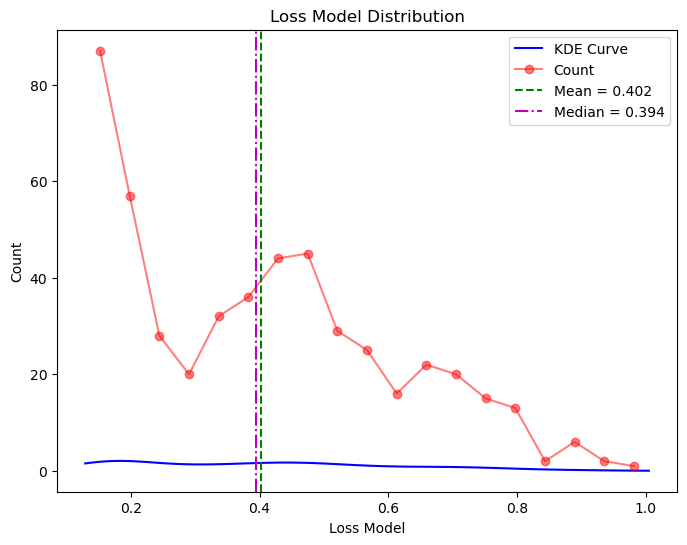


NCC Interval		Average Loss
-0.1-0.0		0.0966 (20747 samples)
-0.2--0.1		0.1186 (22128 samples)
-0.3--0.2		0.1412 (21715 samples)
-0.4--0.3		0.1722 (22575 samples)
-0.5--0.4		0.2140 (21477 samples)
-0.6--0.5		0.2689 (18532 samples)
-0.7--0.6		0.3401 (11984 samples)
-0.8--0.7		0.4229 (4692 samples)
-0.9--0.8		0.5167 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0836 (21562 samples)
0.1-0.2		0.0749 (20116 samples)
0.2-0.3		0.0688 (18407 samples)
0.3-0.4		0.0674 (14862 samples)
0.4-0.5		0.0730 (12001 samples)
0.5-0.6		0.0912 (8923 samples)
0.6-0.7		0.1139 (5511 samples)
0.7-0.8		0.1264 (2747 samples)
0.8-0.9		0.1119 (800 samples)
0.9-1.0		0.0094 (588 samples)


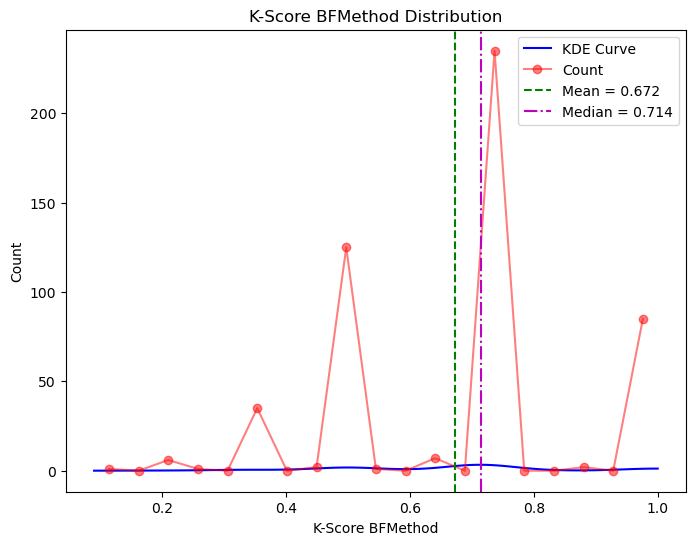

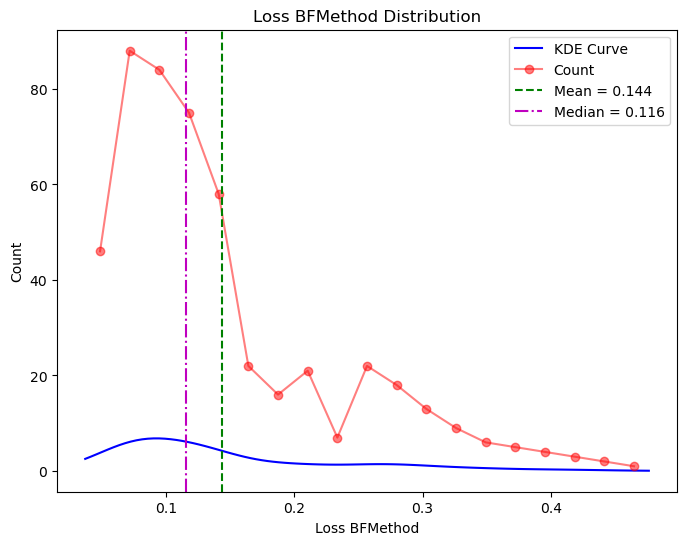

Dimension 64

NCC Interval		Average Loss
-0.1-0.0		0.2397 (20747 samples)
-0.2--0.1		0.2570 (22128 samples)
-0.3--0.2		0.2676 (21715 samples)
-0.4--0.3		0.2979 (22575 samples)
-0.5--0.4		0.3518 (21477 samples)
-0.6--0.5		0.3988 (18532 samples)
-0.7--0.6		0.4576 (11984 samples)
-0.8--0.7		0.5285 (4692 samples)
-0.9--0.8		0.5926 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2452 (21562 samples)
0.1-0.2		0.2491 (20116 samples)
0.2-0.3		0.2556 (18407 samples)
0.3-0.4		0.2601 (14862 samples)
0.4-0.5		0.2498 (12001 samples)
0.5-0.6		0.2270 (8923 samples)
0.6-0.7		0.1904 (5511 samples)
0.7-0.8		0.1386 (2747 samples)
0.8-0.9		0.0949 (800 samples)
0.9-1.0		0.0112 (588 samples)


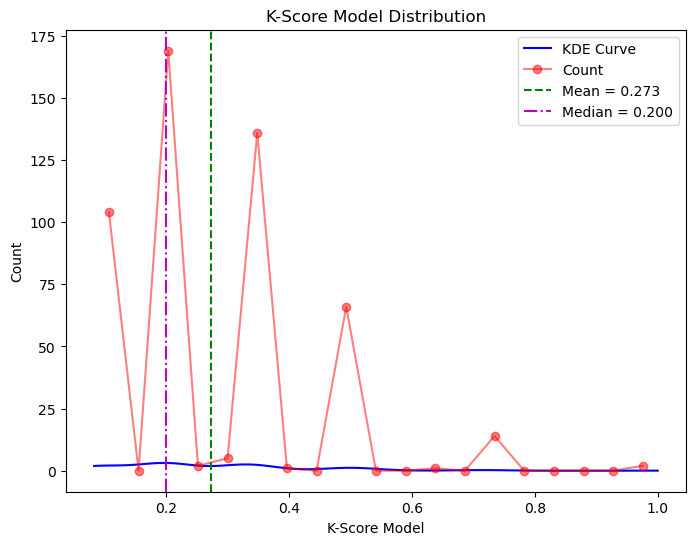

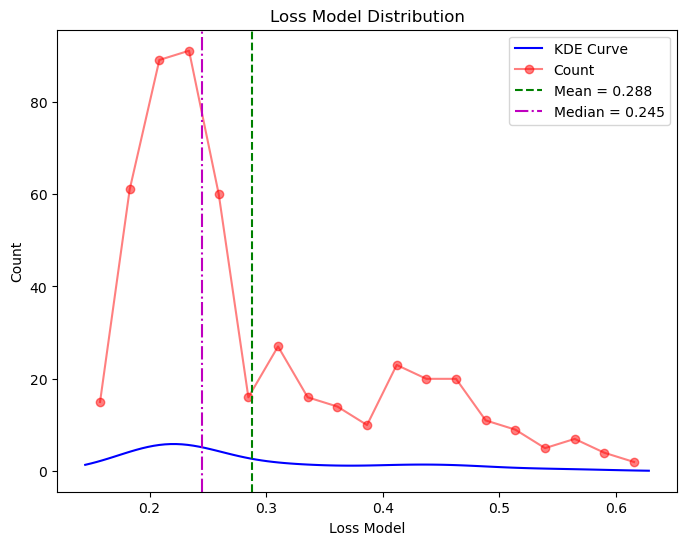


NCC Interval		Average Loss
-0.1-0.0		0.0977 (20747 samples)
-0.2--0.1		0.1211 (22128 samples)
-0.3--0.2		0.1440 (21715 samples)
-0.4--0.3		0.1754 (22575 samples)
-0.5--0.4		0.2187 (21477 samples)
-0.6--0.5		0.2741 (18532 samples)
-0.7--0.6		0.3452 (11984 samples)
-0.8--0.7		0.4293 (4692 samples)
-0.9--0.8		0.5216 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0830 (21562 samples)
0.1-0.2		0.0716 (20116 samples)
0.2-0.3		0.0642 (18407 samples)
0.3-0.4		0.0586 (14862 samples)
0.4-0.5		0.0564 (12001 samples)
0.5-0.6		0.0622 (8923 samples)
0.6-0.7		0.0747 (5511 samples)
0.7-0.8		0.0924 (2747 samples)
0.8-0.9		0.0927 (800 samples)
0.9-1.0		0.0084 (588 samples)


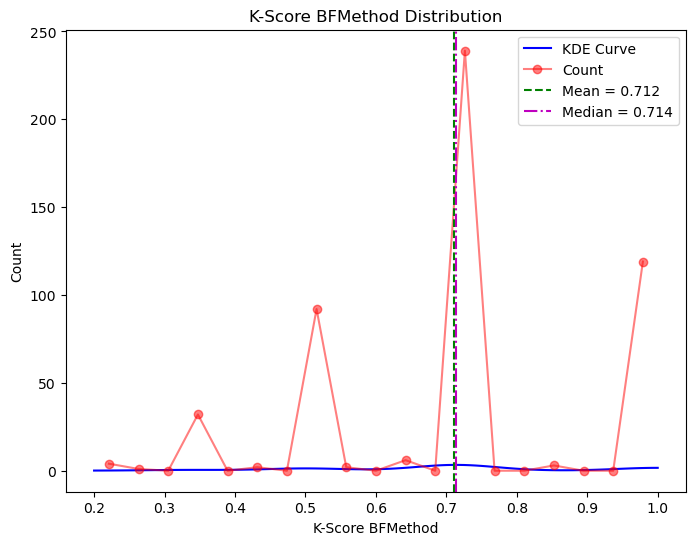

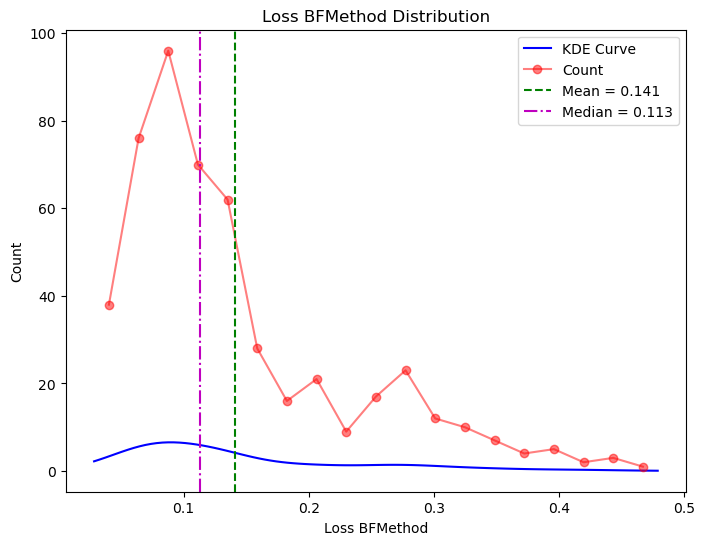

Dimension 128

NCC Interval		Average Loss
-0.1-0.0		0.2586 (20747 samples)
-0.2--0.1		0.2830 (22128 samples)
-0.3--0.2		0.2998 (21715 samples)
-0.4--0.3		0.3294 (22575 samples)
-0.5--0.4		0.3804 (21477 samples)
-0.6--0.5		0.4183 (18532 samples)
-0.7--0.6		0.4836 (11984 samples)
-0.8--0.7		0.5657 (4692 samples)
-0.9--0.8		0.6003 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2443 (21562 samples)
0.1-0.2		0.2348 (20116 samples)
0.2-0.3		0.2287 (18407 samples)
0.3-0.4		0.2244 (14862 samples)
0.4-0.5		0.2112 (12001 samples)
0.5-0.6		0.1906 (8923 samples)
0.6-0.7		0.1542 (5511 samples)
0.7-0.8		0.1196 (2747 samples)
0.8-0.9		0.0939 (800 samples)
0.9-1.0		0.0135 (588 samples)


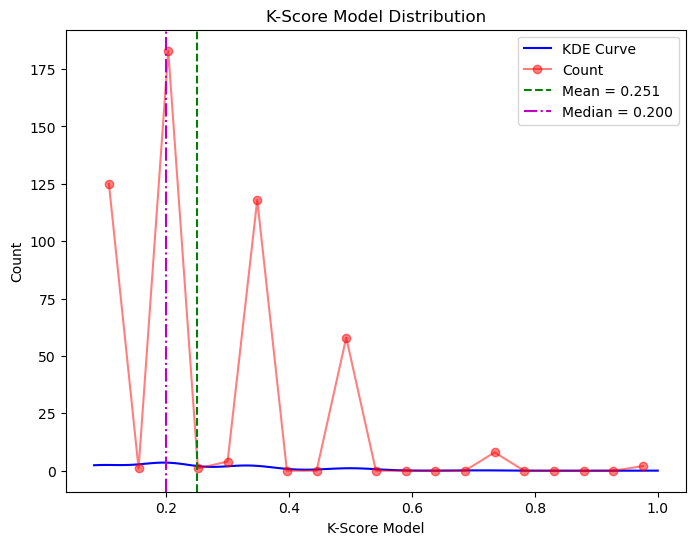

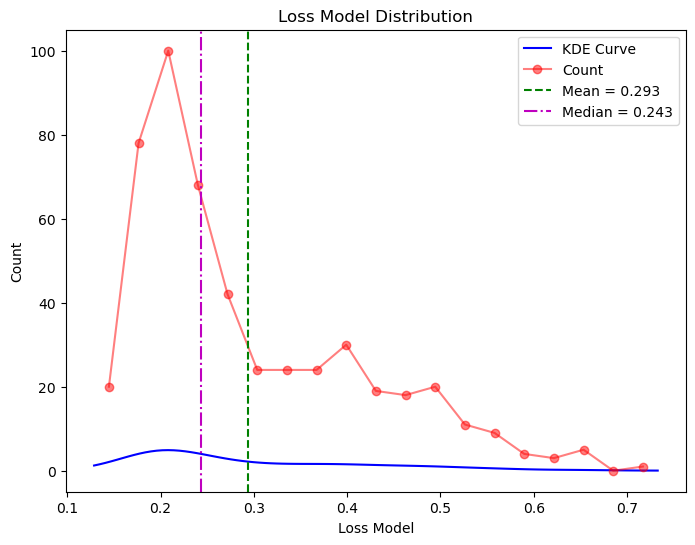


NCC Interval		Average Loss
-0.1-0.0		0.0983 (20747 samples)
-0.2--0.1		0.1218 (22128 samples)
-0.3--0.2		0.1449 (21715 samples)
-0.4--0.3		0.1765 (22575 samples)
-0.5--0.4		0.2200 (21477 samples)
-0.6--0.5		0.2754 (18532 samples)
-0.7--0.6		0.3465 (11984 samples)
-0.8--0.7		0.4311 (4692 samples)
-0.9--0.8		0.5229 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0833 (21562 samples)
0.1-0.2		0.0714 (20116 samples)
0.2-0.3		0.0638 (18407 samples)
0.3-0.4		0.0576 (14862 samples)
0.4-0.5		0.0541 (12001 samples)
0.5-0.6		0.0548 (8923 samples)
0.6-0.7		0.0567 (5511 samples)
0.7-0.8		0.0647 (2747 samples)
0.8-0.9		0.0685 (800 samples)
0.9-1.0		0.0069 (588 samples)


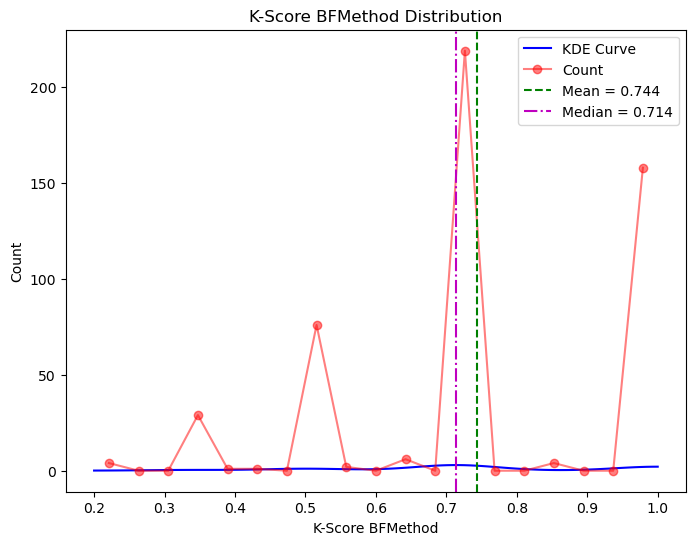

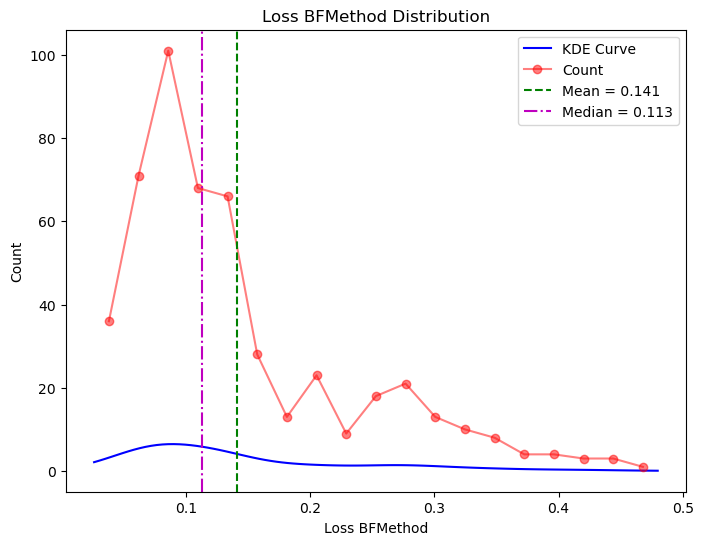

Dimension 256

NCC Interval		Average Loss
-0.1-0.0		0.2602 (20747 samples)
-0.2--0.1		0.2837 (22128 samples)
-0.3--0.2		0.3012 (21715 samples)
-0.4--0.3		0.3246 (22575 samples)
-0.5--0.4		0.3716 (21477 samples)
-0.6--0.5		0.4181 (18532 samples)
-0.7--0.6		0.4870 (11984 samples)
-0.8--0.7		0.5655 (4692 samples)
-0.9--0.8		0.6126 (633 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2532 (21562 samples)
0.1-0.2		0.2555 (20116 samples)
0.2-0.3		0.2547 (18407 samples)
0.3-0.4		0.2549 (14862 samples)
0.4-0.5		0.2375 (12001 samples)
0.5-0.6		0.2187 (8923 samples)
0.6-0.7		0.1852 (5511 samples)
0.7-0.8		0.1360 (2747 samples)
0.8-0.9		0.0954 (800 samples)
0.9-1.0		0.0154 (588 samples)


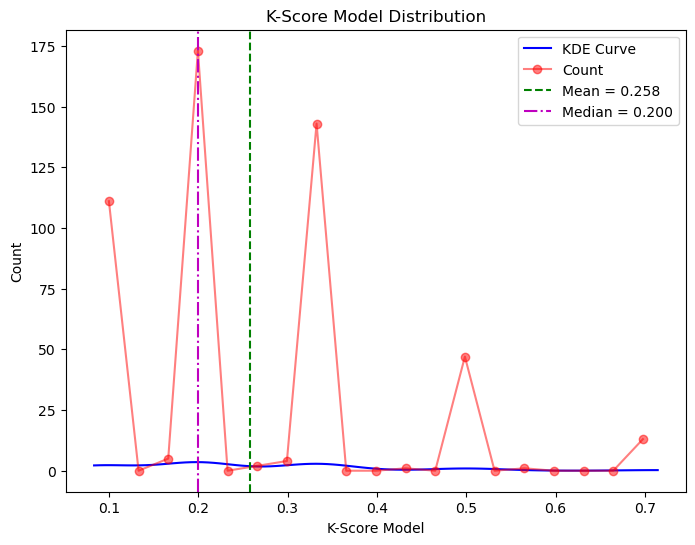

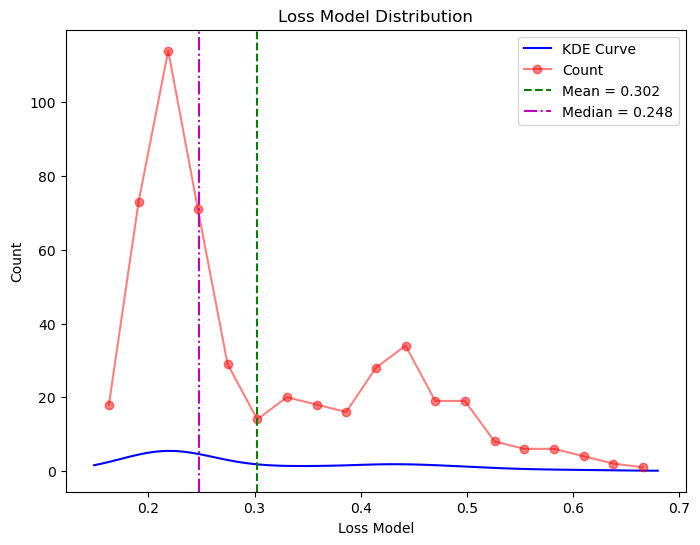

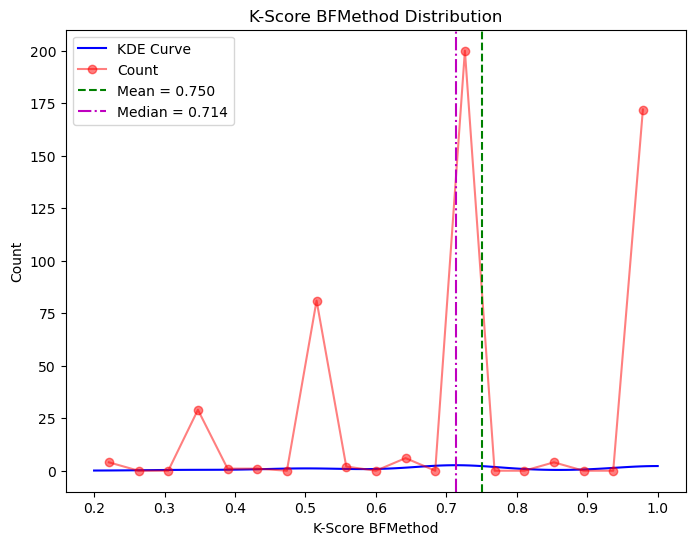

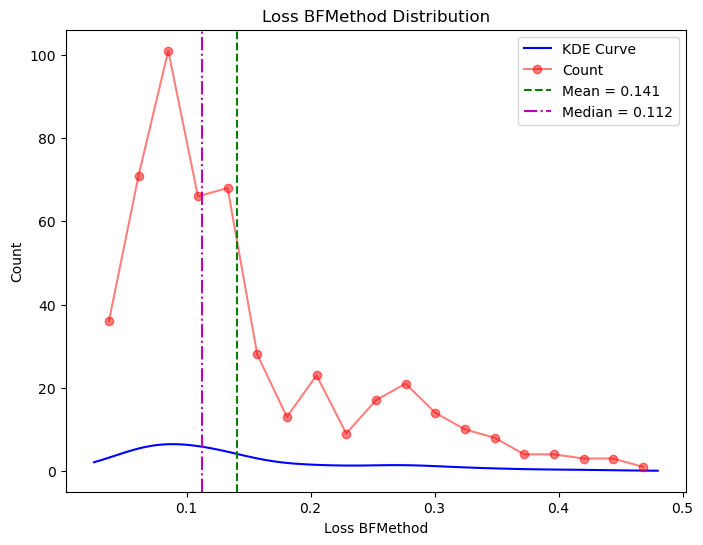

[0.250401776001776, 0.273080303030303, 0.2510982683982684, 0.25750476190476196]
[0.40173824894064664, 0.2875432292034626, 0.29343192458370326, 0.30203324939696496]


In [7]:
#--------------------Visualisation of loss and k-score across dataset across dimensions-------------------
dimensions = [32, 64, 128, 256]
mean = []
k_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:
    print(f"Dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()

    kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_model(testSample, input_dataset, model, k)

    imgcalc.loss_per_ncc_score(ncc_loss_dict)
    imgplt.plot_score_distribution(kscores, "K-Score Model")
    imgplt.plot_score_distribution(losses, "Loss Model")
    mean.append(np.mean(losses))
    k_score.append(np.mean(kscores))
    if dim <= len(testSample):
        matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
        kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_brute(testSample, matrixA, matrixG, k)

        imgcalc.loss_per_ncc_score(ncc_loss_dict)
        imgplt.plot_score_distribution(kscores, "K-Score BFMethod")
        imgplt.plot_score_distribution(losses, "Loss BFMethod")
        
print(k_score)
print(mean)

In [ ]:
# ------------------------ Loss and Kscores of transformed embedding across dataset -----------------------------
dimensions = [32, 64, 128, 256]
loss_original = []
kscore_original = []

input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)

for dim in dimensions: 
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()

    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)

    for i in range(num):
            vectorb = imgcalc.get_vectorb_model(i, model, testSample)

            input2_original = model_vectors[i]
            vectorc_original = []
            loss_value_original = []
            for j in range(num):
                input1_original = model_vectors[j]

                dot_product_orignal = torch.sum(input1_original * input2_original, dim=1)

                vectorc_original.append(dot_product_orignal.detach().cpu().numpy().item())

                NCC_scaled_value = imgcalc.get_NCC_score(testSample[i], testSample[j])

                loss_value = imgcalc.get_loss_value(dot_product_orignal, NCC_scaled_value) 
                loss_value_original.append(loss_value)

            average_loss_original = sum(loss_value_original) / len(loss_value_original)
            average_loss_transformed = sum(loss_value_transformed) / len(loss_value_transformed)
            average_loss_transformed_normalised = sum(loss_value_transformed_normalised) / len(loss_value_transformed_normalised)

            loss_original.append(average_loss_original)

            kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_original, k)
            kscore_original.append(kscore)
            
    kscore_BFMethod, loss_BFMethod, _ = imgcalc.kscore_loss_evaluation_brute(testSample, matrixA, matrixG, k)
    
    imgplt.plot_score_distribution(loss_BFMethod, "Loss BFMethod")
    imgplt.plot_score_distribution(loss_original, "Loss across dataset -- Model original")
    imgplt.plot_score_distribution(kscore_BFMethod, "K-Score BFMethod")
    imgplt.plot_score_distribution(kscore_original, "K-score across dataset -- Model original")

## Metric 3: Mean Squared Differences between vector embeddings
### Visualisation of Mean Squared Difference between model vector embeddings, and Pencorr embeddings across dataset across dimensions


MSE between vector embeddings of dimension 32 for Pencorr (A) and Model:


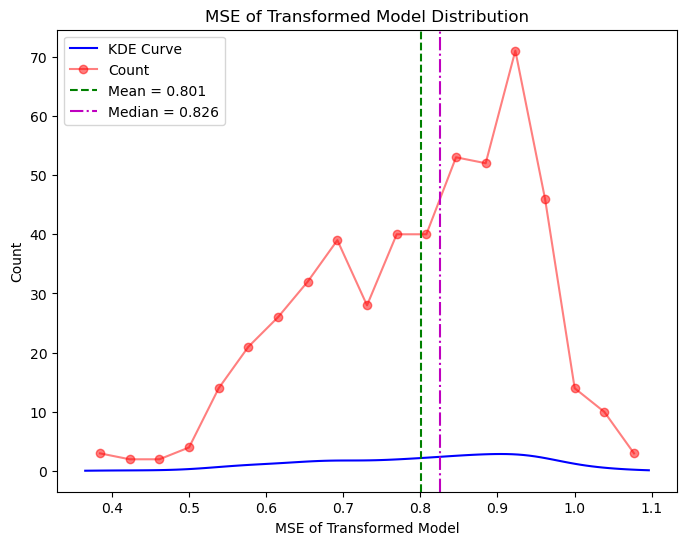

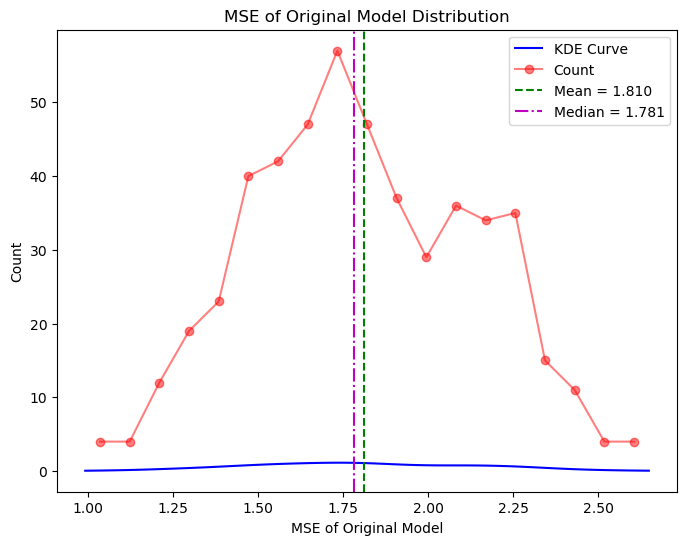


MSE between vector embeddings of dimension 64 for Pencorr (A) and Model:


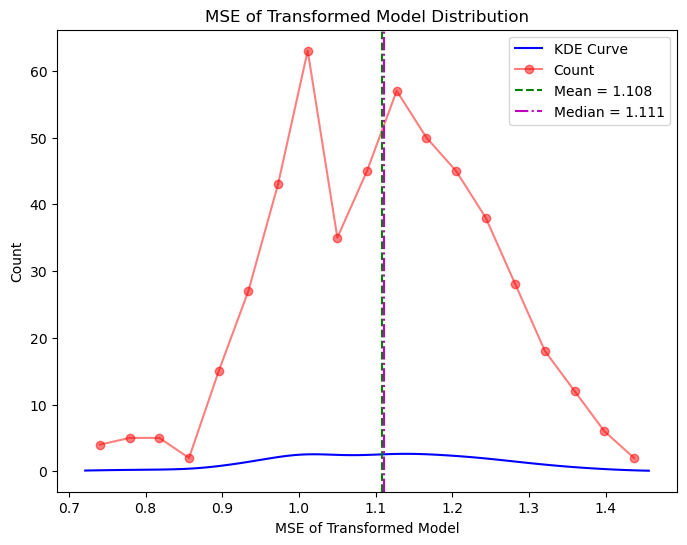

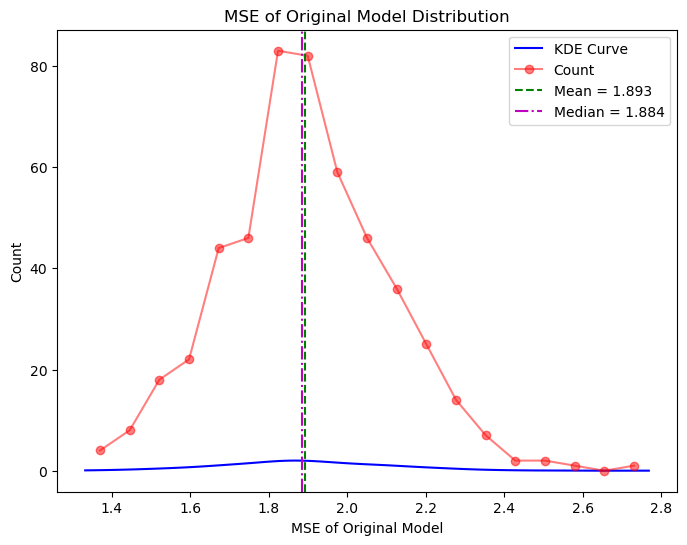


MSE between vector embeddings of dimension 128 for Pencorr (A) and Model:


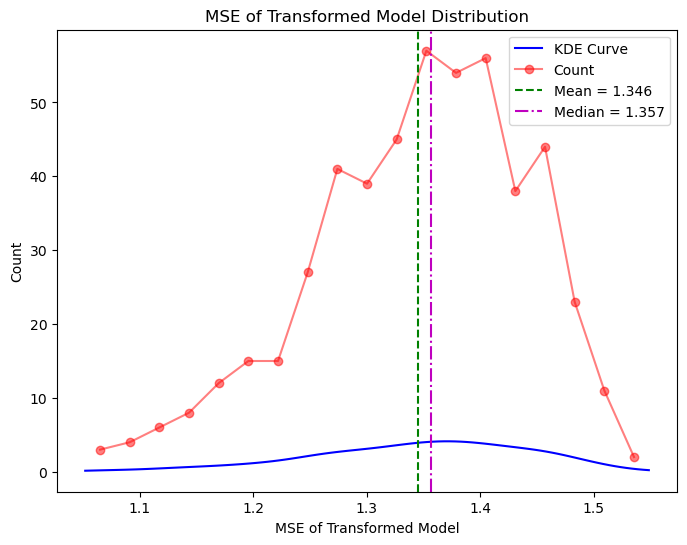

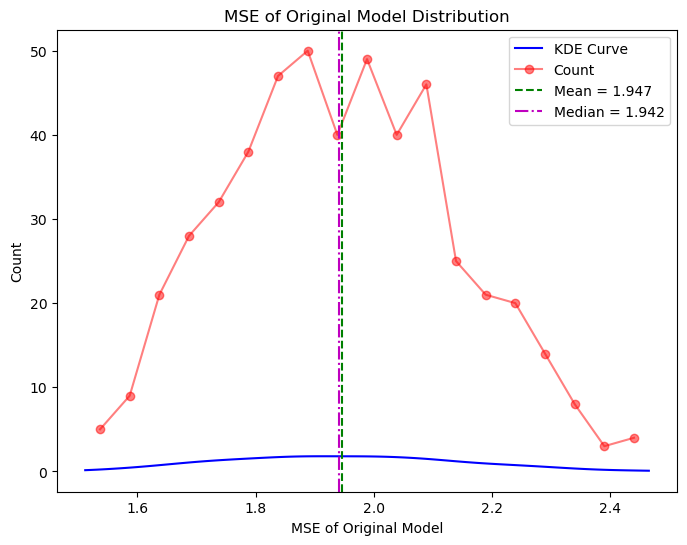


MSE between vector embeddings of dimension 256 for Pencorr (A) and Model:


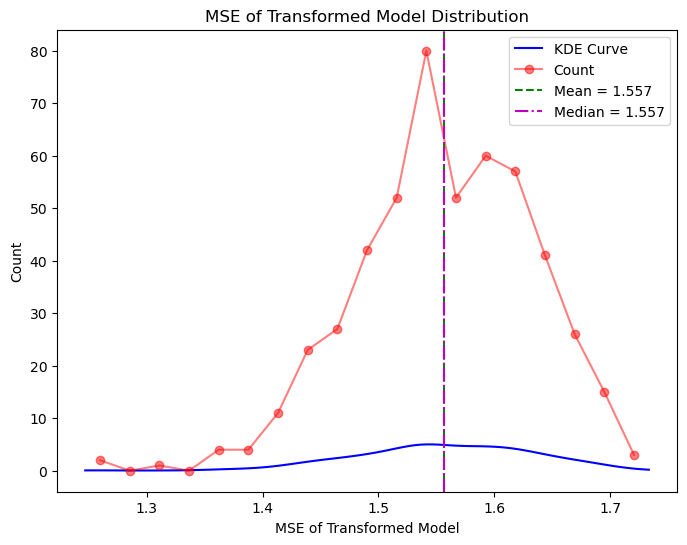

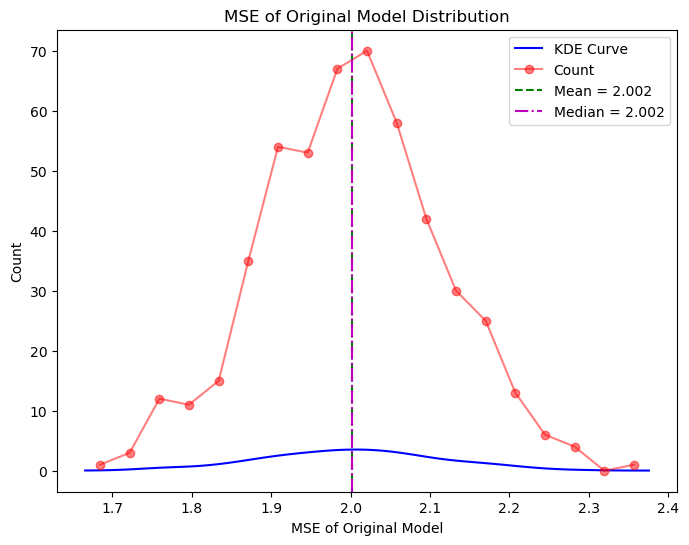

In [9]:
# ------------------------ MSE of embedding across dimensions across dataset -----------------------------
MSD_transformed_normalised = []
MSD_transformed = []
MSD_original = []
dimensions = [32, 64, 128, 256]    
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)
    
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    
    MSE_original = []
    
    print(f"\nMSE between vector embeddings of dimension {dim} for Pencorr (A) and Models:")   
    for i in range(num):

        mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_vectors[i].detach().cpu().numpy())
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_original.append(mean_squared_difference)
    
    MSD_original.append(np.mean(MSE_original))
    imgplt.plot_score_distribution(MSE_original, f"MSE of Original Model")

## Metric 4: F1 Score
### Calculation of F1 Score across dimension using original vector embeddings

In [13]:
#F1 score calculation per dimension
dimensions = [32, 64, 128, 256]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), model_directory, 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()
    f1_index = []
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        MSD_threshold = imgcalc.get_MSE(matrixA[:,top_1_index], model_vectors[top_1_index].detach().cpu().numpy())
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_vectors[j].detach().cpu().numpy())
            # if i ==1 and j == 1:
            #     print(mean_squared_difference, MSD_threshold)
            #     print(f"Embedding of similar image {i} for Model: {model_vectors[i]}")
            #     print(f"Embedding of similar image {j} for Model: {model_vectors[j]}")
            #     print(f"\nEmbedding of image {i} for Pencorr (A'A): {matrixA[:,i]}")
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
    
        #print(TP, TN, FP, FN)
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)
    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")
    

For dimension 32
F1 Score: 8.0199 for dimension 32
For dimension 64
F1 Score: 7.9012 for dimension 64
For dimension 128
F1 Score: 5.7854 for dimension 128
For dimension 256
F1 Score: 5.7929 for dimension 256


In [14]:
#F1 score calculation per dimension transformed normalised
dimensions = [32, 64, 128, 256]
f1_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

    model.eval()
    f1_index = []
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
    
    for i in range(num):
        top_values_b_1, _ = imgcalc.get_top_scores(matrixG[i], k,  print_results=False)
        top_1_index = top_values_b_1[-1][0]
        indices = [x[0] for x in top_values_b_1]
        #print(i, indices)
        MSD_threshold = imgcalc.get_MSE(matrixA[:,top_1_index], model_transformed[top_1_index]/np.linalg.norm(model_transformed[top_1_index].detach().cpu().numpy()))
        
        TP, TN, FP, FN = 0, 0, 0, 0
        
        for j in range(num):
            mean_squared_difference = imgcalc.get_MSE(matrixA[:,i], model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy()))
            predicted = mean_squared_difference <= MSD_threshold
            actual = j in indices

            if predicted and actual:
                TP += 1
            elif predicted and not actual:
                FP += 1
            elif not predicted and actual:
                FN += 1
            elif not predicted and not actual:
                TN += 1
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1 = f1*100
        f1_index.append(f1)
    
    average_f1_dim = np.mean(f1_index)
    f1_score.append(average_f1_dim)
    print(f"F1 Score: {average_f1_dim:.4f} for dimension {dim}")
    

For dimension 32
F1 Score: 19.6276 for dimension 32
For dimension 64
F1 Score: 17.3317 for dimension 64
For dimension 128
F1 Score: 14.2984 for dimension 128
For dimension 256
F1 Score: 15.2721 for dimension 256


# Obtaining the optimal dimension using 4 different metrics above

In [11]:
from collections import Counter
dimensions = [32, 64, 128, 256]

# k_score = [0.250401776001776, 0.273080303030303, 0.2510982683982684, 0.25750476190476196]
# mean = [0.40173824894064664, 0.2875432292034626, 0.29343192458370326, 0.30203324939696496]
# f1_score = [19.6276, 17.3317, 14.2984, 15.2721]

metric1 = np.argmax(k_score)
metric2 = np.argmin(mean)
metric3A = np.argmin(MSD_original)
metric4 = np.argmax(f1_score)

metrics = [
    dimensions[metric1],
    dimensions[metric2],
    dimensions[metric3A],
    dimensions[metric4]
]

optimal_dim = Counter(metrics).most_common(1)[0][0]
print("Optimal Dimension:", optimal_dim)

Optimal Dimension: 32


# Metric 5
## Calculating transformed embedding using Orthogonal Procustes for the optimal embedding dimension using metric 1 and 2

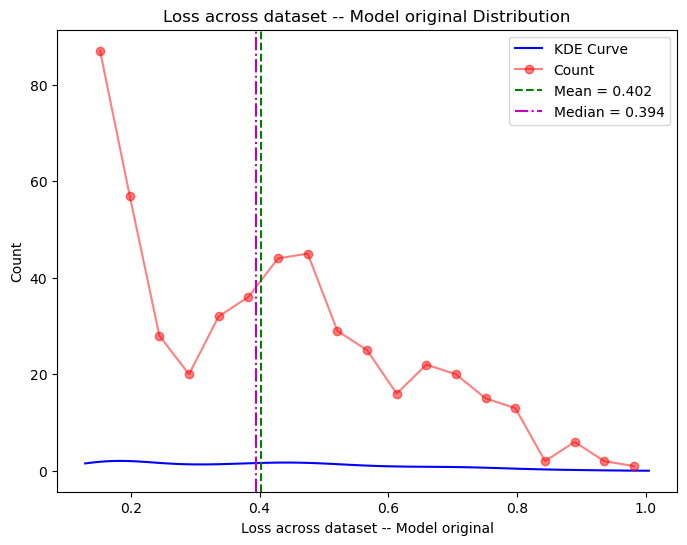

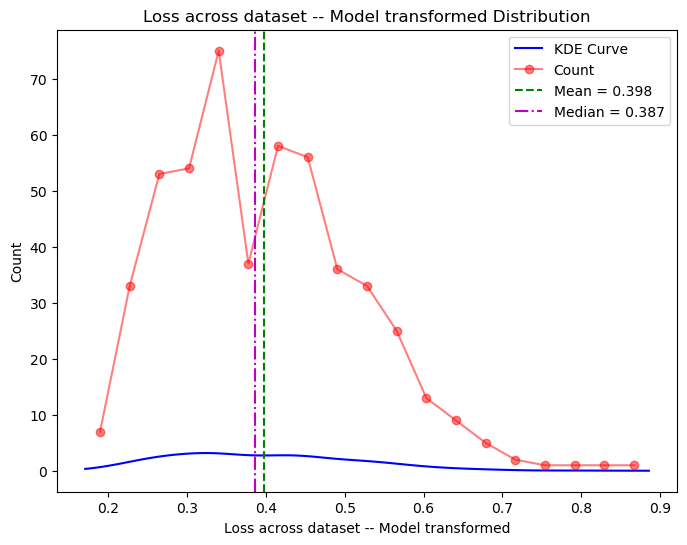

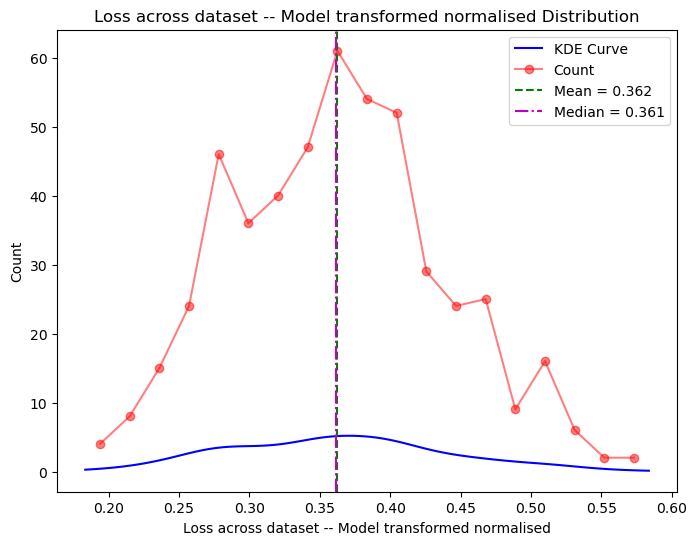

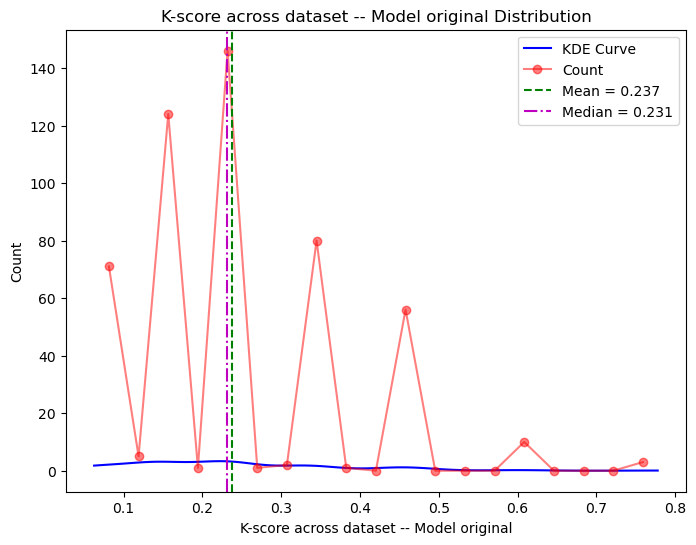

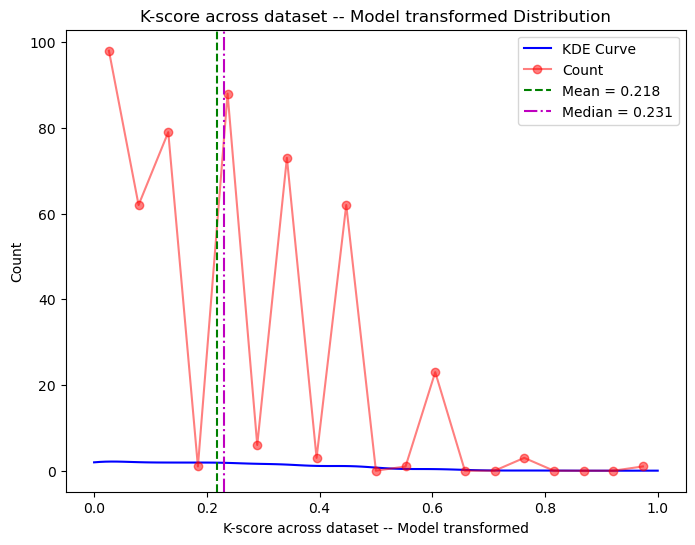

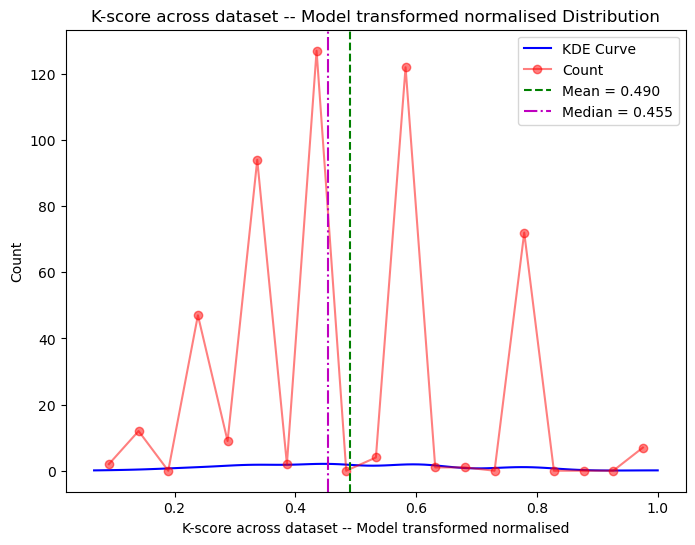

In [12]:
# ------------------------ Loss and Kscores of transformed embedding across dataset -----------------------------
loss_transformed_normalised = []
loss_transformed = []
loss_original = []
kscore_transformed_normalised = []
kscore_transformed = []
kscore_original = []

input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)

dim = optimal_dim  
embeddingType = f"pencorr_{dim}"

model = models.SimpleCNN2(dimensions=dim, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model/model_dump_32x32", 
                 f'best_model_{imageType}_{dim}d_convlayer1.pt'), weights_only=True))

model.eval()

matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
dot_product_matrix = np.dot(matrixA.T, matrixA)

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]

for i in range(num):
        vectorb = imgcalc.get_vectorb_model(i, model, testSample)

        input2_original = model_vectors[i]
        input2_transformed = model_transformed[i]
        #since after transformation, its not a unit vector
        input2_transformed_normalised =  model_transformed[i]/np.linalg.norm(model_transformed[i].detach().cpu().numpy())
        vectorc_original = []
        vectorc_transformed = []
        vectorc_transformed_normalised = []

        loss_value_transformed_normalised = []
        loss_value_transformed = []
        loss_value_original = []
        for j in range(num):
            input1_original = model_vectors[j]
            #since after transformation, its not a unit vector
            input1_transformed = model_transformed[j]
            input1_transformed_normalised =  model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy())
            
            dot_product_orignal = torch.sum(input1_original * input2_original, dim=1)
            dot_product_transformed = torch.sum(input1_transformed * input2_transformed, dim=1)
            dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised, dim=1)
            
            vectorc_original.append(dot_product_orignal.detach().cpu().numpy().item())
            vectorc_transformed.append(dot_product_transformed.detach().cpu().numpy().item())
            vectorc_transformed_normalised.append(dot_product_transformed_normalised.detach().cpu().numpy().item())

            NCC_scaled_value = imgcalc.get_NCC_score(testSample[i], testSample[j])
            
            loss_value = imgcalc.get_loss_value(dot_product_orignal, NCC_scaled_value) 
            loss_value_original.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed, NCC_scaled_value) 
            loss_value_transformed.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed_normalised, NCC_scaled_value) 
            loss_value_transformed_normalised.append(loss_value)

        average_loss_original = sum(loss_value_original) / len(loss_value_original)
        average_loss_transformed = sum(loss_value_transformed) / len(loss_value_transformed)
        average_loss_transformed_normalised = sum(loss_value_transformed_normalised) / len(loss_value_transformed_normalised)

        loss_original.append(average_loss_original)
        loss_transformed.append(average_loss_transformed)
        loss_transformed_normalised.append(average_loss_transformed_normalised)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_original, k)
        kscore_original.append(kscore)
    
        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed, k)
        kscore_transformed.append(kscore)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed_normalised, k)
        kscore_transformed_normalised.append(kscore)
    
imgplt.plot_score_distribution(loss_original, "Loss across dataset -- Model original")
imgplt.plot_score_distribution(loss_transformed, "Loss across dataset -- Model transformed")
imgplt.plot_score_distribution(loss_transformed_normalised, "Loss across dataset -- Model transformed normalised")
imgplt.plot_score_distribution(kscore_original, "K-score across dataset -- Model original")
imgplt.plot_score_distribution(kscore_transformed, "K-score across dataset -- Model transformed")
imgplt.plot_score_distribution(kscore_transformed_normalised, "K-score across dataset -- Model transformed normalised")

In [ ]:
# -------------------- Using normalized embedding loss function to determine dimension--------------------
def find_optimal_dim(losses, eps=0.05): 
    """ losses: dict {dimension: L(d)} """
    L_inf = min(losses.values()) 
    for d in sorted(losses.keys()): 
        if (losses[d] - L_inf)/L_inf <= eps: 
            return d 
    return max(losses.keys())


In [7]:
# -------------- mega insane debug -----------------
tolerance = 1e-6
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

rank = np.linalg.matrix_rank(matrixG)
print("Rank of the matrixG:", rank)

nDim = 64
# original image product matrix not PSD, after transformation,
matrixGprime = embedfunc.pencorr(matrixG, nDim) #reduce matrixG rank from image set size to nDim

print("g pirme")
rank = np.linalg.matrix_rank(matrixGprime) #156
''' 
given 753 unique training samples, rank of matrixG is by right 753 
ndim 512: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 256: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 64: rank of g' = 64, 64 positive eigenvalues for g', 380 positive eigenvalues for g

somewhere in the algorithm, it is coded such that pencorr striaghtaway finds the optimum rank of a matrix and minimises it
once rank is minimised to its optimum, the number of positive eigenvalues is only that number.
unless we set nDim < rank, we cannot change the number of positive eigenvalues.
this overall limits the number of dimensions we can test. 

essentially, since rank of g' determines the vector space formed by the rows and columns (linearly independent rows or columns in matrix),
the rank of a matrix is the number of non-zero eigenvalues of a matrix, which is why limiting the rank of the matrix to 120 only give
120 non-zero elements in our embedding dimension. 
'''
print("Rank of the matrixG':", rank)
eigenvalues, eigenvectors = np.linalg.eig(matrixGprime)
print(matrixGprime.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape) #753x753
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) 
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]} {matrixA.shape} {matrixA[:,index1].size}")
count_not_close_to_zero = np.sum(np.abs(matrixA[:,index1]) > tolerance)
print("Number of elements not close to tolerance 1e-5:", count_not_close_to_zero)

count_to_zero = np.sum(np.abs(matrixA[:,index1]) > 0)
print("Number of elements not close to 0:", count_to_zero)

print("g")
eigenvalues, eigenvectors = np.linalg.eig(matrixG)
print(matrixG.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape)
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) #380 ????????
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

Rank of the matrixG: 500
g pirme
Rank of the matrixG': 154
(500, 500)
(500,)
(500, 500)
Number of eigenvalues greater than tolerance: 154

Embedding of image 182 for Pencorr (A'A): [-5.47267208e-01  6.85274121e-02 -2.38028460e-01 -2.74942382e-01
  1.27518230e-01  4.40561892e-01  1.22415044e-01 -1.47233858e-01
 -7.56385998e-02 -5.82657803e-02  4.18958296e-02 -1.20776909e-01
  4.97361413e-02 -1.27383536e-02 -1.20196108e-01 -7.03198724e-02
 -3.63524779e-03  1.62504185e-02 -1.21541367e-01 -6.82538322e-02
  6.95328997e-03 -1.34012704e-01 -1.55183642e-02  2.81475156e-02
 -6.03882115e-02  6.45322863e-02  1.73894661e-01  7.13490646e-02
  4.15358624e-02  6.27635521e-03 -3.86025105e-02 -2.83082920e-02
 -2.20404262e-02  1.05742827e-01 -1.40238653e-01  1.35955846e-02
  1.53754912e-01 -7.35932485e-03 -3.89920821e-02  6.95864982e-02
 -9.13883895e-02  5.07247576e-02  5.03209368e-02  6.59893317e-02
 -6.56235045e-02  9.85685401e-02  3.58867222e-02 -4.84742996e-02
  4.94295154e-02  4.37712532e-02  8.159